In [15]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import seaborn as sns
# import plotly.express as px
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import mlab
from matplotlib.ticker import FuncFormatter
# matplotlib.style.use('ggplot')

import itertools
from itertools import islice
import sqlite3

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_columns', None)
# %load_ext Cython

In [2]:
## Format Initial Data Columns
def format_init(df):
    df.columns = df.columns.str.lower().str.strip()
    df["DateTime"] = pd.to_datetime(df["date"] + " " + df["time"])
    df["Date"] = pd.to_datetime(df["date"], format="%m/%d/%Y")
    df["Time"] = pd.to_datetime(df["time"], format="%H:%M:%S").dt.strftime('%H:%M')
    df[["entries", "exits"]] = df[["entries", "exits"]].apply(pd.to_numeric, downcast="float")
    df["Turnstile_ID"] = df["c/a"] + "-" + df["unit"] + "-" + df["scp"]
    df.rename(columns={"station": "Station", 
                       "division": "Division",
                       "description": "Desc",
                       "desc": "Desc",
                       "entries": "Entries",
                       "exits": "Exits",
                       "line name": "LineName"}, inplace=True)
    return df[['DateTime', 'Date', 'Time', 'Division', 'Desc', 
               'Station', 'LineName', 'Turnstile_ID', 
               'Entries', 'Exits']].set_index("DateTime")

## Add Time Features
def add_time_features(df):
    # Year
    df["Year"] = pd.to_numeric(df.index.year, downcast='integer')
    # Month
    df["Month"] = pd.to_numeric(df.index.month, downcast='integer')
    # Day of Week Index and Spelled Out
    df["DOW_Index"] = pd.to_numeric(df.index.weekday, downcast='integer')
    df["DOW"] = df.index.day_name()#.astype("category")
    # Hour (Roundest to the nearest Hour)
    df["Hour"] = pd.to_numeric(df.index.round('H').hour, downcast='integer')
    #pd.to_numeric(s, downcast='integer')
    return df[['Date', 'Time', 'Division', 'Desc', 'Station', 'LineName', 'Turnstile_ID',
               'Year', 'Month', 'DOW_Index', 'DOW', 'Hour', 'Entries', 'Exits']]
    

# ## Add Train Line Features
# def add_trainline_features(df):
#     # Get unique list of Train Lines
#     TrainLines = sorted(list(set([*"".join(df.LineName.unique())])))
#     # Create Feature for Each Line and Enter Boolean Value if Observation contains Line
#     for t in TrainLines:
#         df[("Line_" + t)] = df["LineName"].apply(lambda x: True if t in x else False)
#     return df


## Group By Turnstile and return Dictionary with Turnstile as Key and Data Frame as Value
def groupby_turnstile(df):
    df_obj = {}
    for group_name, df_group in df.groupby(["Turnstile_ID"], as_index=False):
        df_obj[group_name] = df_group
    return df_obj

## Filter Entries and Exits to get "by grouping" (day, hour, etc.) values
def filter_entries_exits(name, df):
#     startTime = time.time()
    df["Entries_Corrected"] = pd.Series.diff(df["Entries"]).fillna(0.0).apply(lambda x: abs(x) if x<0 else x).astype(int)
    df["Exits_Corrected"] = pd.Series.diff(df['Exits']).fillna(0.0).apply(lambda x: abs(x) if x<0 else x).astype(int)
#     print(name, "complete")
#     executionTime = (time.time() - startTime)
#     print("Execution time in seconds:", str(executionTime))
    return df

## Iterate through Dictionary
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [3]:
origin_data = pd.read_csv("./data/Turnstile_Usage_Data_2014-10-18_thru_2022-09-24.csv", low_memory=False, chunksize=1000000, iterator=True)
origin_data = pd.concat(origin_data, ignore_index=True)
origin_data

DateTime        Date      Time Division     Desc  \
0         2014-10-11 01:00:00  2014-10-11  01:00:00      BMT  REGULAR   
1         2014-10-11 05:00:00  2014-10-11  05:00:00      BMT  REGULAR   
2         2014-10-11 09:00:00  2014-10-11  09:00:00      BMT  REGULAR   
3         2014-10-11 13:00:00  2014-10-11  13:00:00      BMT  REGULAR   
4         2014-10-11 17:00:00  2014-10-11  17:00:00      BMT  REGULAR   
...                       ...         ...       ...      ...      ...   
83129623  2022-09-16 05:00:00  2022-09-16  05:00:00      RIT  REGULAR   
83129624  2022-09-16 09:00:00  2022-09-16  09:00:00      RIT  REGULAR   
83129625  2022-09-16 13:00:00  2022-09-16  13:00:00      RIT  REGULAR   
83129626  2022-09-16 17:00:00  2022-09-16  17:00:00      RIT  REGULAR   
83129627  2022-09-16 21:00:00  2022-09-16  21:00:00      RIT  REGULAR   

                Station LineName         Turnstile_ID       Entries  \
0          WHITEHALL ST       R1   A060-R001-00-00-00 805439.000000   
1          WHITEHALL ST       R1   A060-R001-00-00-00 805459.000000   
2          WHITEHALL ST       R1   A060-R001-00-00-00 805589.000000   
3          WHITEHALL ST       R1   A060-R001-00-00-00 805834.000000   
4          WHITEHALL ST       R1   A060-R001-00-00-00 806150.000000   
...                 ...      ...                  ...           ...   
83129623  RIT-ROOSEVELT        R  TRAM2-R469-00-05-01      0.000000   
83129624  RIT-ROOSEVELT        R  TRAM2-R469-00-05-01      0.000000   
83129625  RIT-ROOSEVELT        R  TRAM2-R469-00-05-01      0.000000   
83129626  RIT-ROOSEVELT        R  TRAM2-R469-00-05-01      0.000000   
83129627  RIT-ROOSEVELT        R  TRAM2-R469-00-05-01      0.000000   

                  Exits  Year  Month  Day  DOW_Index       DOW  Hour  
0        1141080.000000  2014     10   11          5  Saturday     1  
1        1141141.000000  2014     10   11          5  Saturday     5  
2        1141257.000000  2014     10   11          5  Saturday     9  
3        1141512.000000  2014     10   11          5  Saturday    13  
4        1141903.000000  2014     10   11          5  Saturday    17  
...                 ...   ...    ...  ...        ...       ...   ...  
83129623     804.000000  2022      9   16          4    Friday     5  
83129624     804.000000  2022      9   16          4    Friday     9  
83129625     804.000000  2022      9   16          4    Friday    13  
83129626     804.000000  2022      9   16          4    Friday    17  
83129627     804.000000  2022      9   16          4    Friday    21  

[83129628 rows x 16 columns]

In [4]:
origin_data = origin_data.set_index("DateTime")

display(origin_data)
display(origin_data.info())

Date      Time Division     Desc        Station  \
DateTime                                                                     
2014-10-11 01:00:00  2014-10-11  01:00:00      BMT  REGULAR   WHITEHALL ST   
2014-10-11 05:00:00  2014-10-11  05:00:00      BMT  REGULAR   WHITEHALL ST   
2014-10-11 09:00:00  2014-10-11  09:00:00      BMT  REGULAR   WHITEHALL ST   
2014-10-11 13:00:00  2014-10-11  13:00:00      BMT  REGULAR   WHITEHALL ST   
2014-10-11 17:00:00  2014-10-11  17:00:00      BMT  REGULAR   WHITEHALL ST   
...                         ...       ...      ...      ...            ...   
2022-09-16 05:00:00  2022-09-16  05:00:00      RIT  REGULAR  RIT-ROOSEVELT   
2022-09-16 09:00:00  2022-09-16  09:00:00      RIT  REGULAR  RIT-ROOSEVELT   
2022-09-16 13:00:00  2022-09-16  13:00:00      RIT  REGULAR  RIT-ROOSEVELT   
2022-09-16 17:00:00  2022-09-16  17:00:00      RIT  REGULAR  RIT-ROOSEVELT   
2022-09-16 21:00:00  2022-09-16  21:00:00      RIT  REGULAR  RIT-ROOSEVELT   

                    LineName         Turnstile_ID       Entries  \
DateTime                                                          
2014-10-11 01:00:00       R1   A060-R001-00-00-00 805439.000000   
2014-10-11 05:00:00       R1   A060-R001-00-00-00 805459.000000   
2014-10-11 09:00:00       R1   A060-R001-00-00-00 805589.000000   
2014-10-11 13:00:00       R1   A060-R001-00-00-00 805834.000000   
2014-10-11 17:00:00       R1   A060-R001-00-00-00 806150.000000   
...                      ...                  ...           ...   
2022-09-16 05:00:00        R  TRAM2-R469-00-05-01      0.000000   
2022-09-16 09:00:00        R  TRAM2-R469-00-05-01      0.000000   
2022-09-16 13:00:00        R  TRAM2-R469-00-05-01      0.000000   
2022-09-16 17:00:00        R  TRAM2-R469-00-05-01      0.000000   
2022-09-16 21:00:00        R  TRAM2-R469-00-05-01      0.000000   

                             Exits  Year  Month  Day  DOW_Index       DOW  \
DateTime                                                                    
2014-10-11 01:00:00 1141080.000000  2014     10   11          5  Saturday   
2014-10-11 05:00:00 1141141.000000  2014     10   11          5  Saturday   
2014-10-11 09:00:00 1141257.000000  2014     10   11          5  Saturday   
2014-10-11 13:00:00 1141512.000000  2014     10   11          5  Saturday   
2014-10-11 17:00:00 1141903.000000  2014     10   11          5  Saturday   
...                            ...   ...    ...  ...        ...       ...   
2022-09-16 05:00:00     804.000000  2022      9   16          4    Friday   
2022-09-16 09:00:00     804.000000  2022      9   16          4    Friday   
2022-09-16 13:00:00     804.000000  2022      9   16          4    Friday   
2022-09-16 17:00:00     804.000000  2022      9   16          4    Friday   
2022-09-16 21:00:00     804.000000  2022      9   16          4    Friday   

                     Hour  
DateTime                   
2014-10-11 01:00:00     1  
2014-10-11 05:00:00     5  
2014-10-11 09:00:00     9  
2014-10-11 13:00:00    13  
2014-10-11 17:00:00    17  
...                   ...  
2022-09-16 05:00:00     5  
2022-09-16 09:00:00     9  
2022-09-16 13:00:00    13  
2022-09-16 17:00:00    17  
2022-09-16 21:00:00    21  

[83129628 rows x 15 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 83129628 entries, 2014-10-11 01:00:00 to 2022-09-16 21:00:00
Data columns (total 15 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Date          object 
 1   Time          object 
 2   Division      object 
 3   Desc          object 
 4   Station       object 
 5   LineName      object 
 6   Turnstile_ID  object 
 7   Entries       float64
 8   Exits         float64
 9   Year          int64  
 10  Month         int64  
 11  Day           int64  
 12  DOW_Index     int64  
 13  DOW           object 
 14  Hour          int64  
dtypes: float64(2), int64(5), object(8)
memory usage: 9.9+ GB


None

In [5]:
origin_data["Date"] = pd.to_datetime(origin_data.Date)
origin_data["Time"] = pd.to_datetime(origin_data["Time"], format="%H:%M:%S").dt.strftime('%H:%M')

data = origin_data.copy()

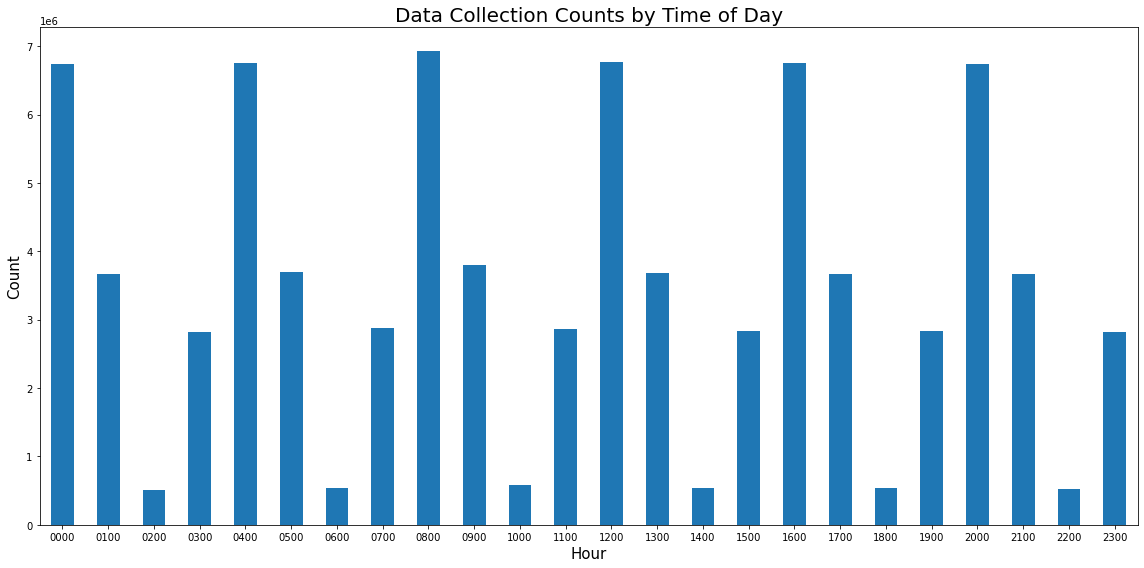

In [11]:
# sns.set(style="darkgrid")
sns.color_palette("colorblind")


data.reset_index().sort_values(["Station", "Date", "Hour", "Turnstile_ID", "Entries"]).groupby(["Hour"]).count()["Date"].reset_index().plot(x="Hour",
                                                                                                                                            y="Date",
                                                                                                                                            kind="bar",
                                                                                                                                            figsize=(16,8),
                                                                                                                                            legend=False)
plt.title("Data Collection Counts by Time of Day", fontsize=20)
plt.xlabel("Hour", fontsize=15)
x_ticks = np.arange(0,24)
x_tick_labels = np.array(["".join(["".join([str(0) for j in range(4-len(str(i)))]), str(i)]) if len(str(i))<4 else str(i) for i in np.arange(0, 2400, 100)])
plt.xticks(x_ticks, x_tick_labels, rotation=0)
plt.ylabel("Count", fontsize=15)

plt.tight_layout()
plt.savefig("./img/Data_Collection_By_Hour.png", dpi=100)
plt.show()

In [7]:
data.head()

Date   Time Division     Desc       Station  \
DateTime                                                                
2014-10-11 01:00:00 2014-10-11  01:00      BMT  REGULAR  WHITEHALL ST   
2014-10-11 05:00:00 2014-10-11  05:00      BMT  REGULAR  WHITEHALL ST   
2014-10-11 09:00:00 2014-10-11  09:00      BMT  REGULAR  WHITEHALL ST   
2014-10-11 13:00:00 2014-10-11  13:00      BMT  REGULAR  WHITEHALL ST   
2014-10-11 17:00:00 2014-10-11  17:00      BMT  REGULAR  WHITEHALL ST   

                    LineName        Turnstile_ID       Entries          Exits  \
DateTime                                                                        
2014-10-11 01:00:00       R1  A060-R001-00-00-00 805439.000000 1141080.000000   
2014-10-11 05:00:00       R1  A060-R001-00-00-00 805459.000000 1141141.000000   
2014-10-11 09:00:00       R1  A060-R001-00-00-00 805589.000000 1141257.000000   
2014-10-11 13:00:00       R1  A060-R001-00-00-00 805834.000000 1141512.000000   
2014-10-11 17:00:00       R1  A060-R001-00-00-00 806150.000000 1141903.000000   

                     Year  Month  Day  DOW_Index       DOW  Hour  
DateTime                                                          
2014-10-11 01:00:00  2014     10   11          5  Saturday     1  
2014-10-11 05:00:00  2014     10   11          5  Saturday     5  
2014-10-11 09:00:00  2014     10   11          5  Saturday     9  
2014-10-11 13:00:00  2014     10   11          5  Saturday    13  
2014-10-11 17:00:00  2014     10   11          5  Saturday    17

In [21]:
for i in range(24):
    if i < 10:
        print("Time:", "0"+str(i)+":00\t\tUnique Stations where Data was collected:", str(len(data[data.Hour == i].Station.unique())))
    else:
        print("Time:", str(i)+":00\t\tUnique Stations where Data was collected:", str(len(data[data.Hour == i].Station.unique())))

Time: 00:00		Unique Stations where Data was collected: 568
Time: 01:00		Unique Stations where Data was collected: 359
Time: 02:00		Unique Stations where Data was collected: 56
Time: 03:00		Unique Stations where Data was collected: 361
Time: 04:00		Unique Stations where Data was collected: 567
Time: 05:00		Unique Stations where Data was collected: 446
Time: 06:00		Unique Stations where Data was collected: 426
Time: 07:00		Unique Stations where Data was collected: 551
Time: 08:00		Unique Stations where Data was collected: 572
Time: 09:00		Unique Stations where Data was collected: 562
Time: 10:00		Unique Stations where Data was collected: 537
Time: 11:00		Unique Stations where Data was collected: 535
Time: 12:00		Unique Stations where Data was collected: 569
Time: 13:00		Unique Stations where Data was collected: 480
Time: 14:00		Unique Stations where Data was collected: 405
Time: 15:00		Unique Stations where Data was collected: 493
Time: 16:00		Unique Stations where Data was collected: 57

In [9]:
df = data.copy()

In [10]:
## Sort Data Frame and group Hour Feature into even 4 hour intervals
df = df.reset_index().sort_values(["Station", "Date", "Hour", "Turnstile_ID", "Entries", "Exits"]).drop_duplicates(keep="first")

df.loc[((df.Hour == 1) | (df.Hour == 2) | (df.Hour == 3) | (df.Hour == 4)), "Hour"] = 4
df.loc[((df.Hour == 5) | (df.Hour == 6) | (df.Hour == 7) | (df.Hour == 8)), "Hour"] = 8
df.loc[((df.Hour == 9) | (df.Hour == 10) | (df.Hour == 11) | (df.Hour == 12)), "Hour"] = 12
df.loc[((df.Hour == 13) | (df.Hour == 14) | (df.Hour == 15) | (df.Hour == 16)), "Hour"] = 16
df.loc[((df.Hour == 17) | (df.Hour == 18) | (df.Hour == 19) | (df.Hour == 20)), "Hour"] = 20
df.loc[((df.Hour == 21) | (df.Hour == 22) | (df.Hour == 23) | (df.Hour == 0)), "Hour"] = 0

In [16]:
df.dtypes

DateTime                object
Date            datetime64[ns]
Time                    object
Division                object
Desc                    object
Station                 object
LineName                object
Turnstile_ID            object
Entries                float64
Exits                  float64
Year                     int64
Month                    int64
Day                      int64
DOW_Index                int64
DOW                     object
Hour                     int64
dtype: object

In [17]:
# Filter for features that are useful
df = df[["Date", "Month", "Day", "Year", "Hour", "DOW_Index",
         "Station", "Turnstile_ID", "Entries", "Exits"]].copy()
df.set_index(pd.to_datetime(df["Date"]) + df["Hour"].astype('timedelta64[h]'), inplace=True)
df

Date  Month  Day  Year  Hour  DOW_Index     Station  \
2015-12-26 04:00:00 2015-12-26     12   26  2015     4          5        1 AV   
2015-12-26 04:00:00 2015-12-26     12   26  2015     4          5        1 AV   
2015-12-26 04:00:00 2015-12-26     12   26  2015     4          5        1 AV   
2015-12-26 04:00:00 2015-12-26     12   26  2015     4          5        1 AV   
2015-12-26 04:00:00 2015-12-26     12   26  2015     4          5        1 AV   
...                        ...    ...  ...   ...   ...        ...         ...   
2015-12-25 20:00:00 2015-12-25     12   25  2015    20          4  ZEREGA AVE   
2015-12-25 20:00:00 2015-12-25     12   25  2015    20          4  ZEREGA AVE   
2015-12-25 20:00:00 2015-12-25     12   25  2015    20          4  ZEREGA AVE   
2015-12-25 20:00:00 2015-12-25     12   25  2015    20          4  ZEREGA AVE   
2015-12-25 20:00:00 2015-12-25     12   25  2015    20          4  ZEREGA AVE   

                           Turnstile_ID          Entries            Exits  
2015-12-26 04:00:00  H007-R248-00-00-00  10536080.000000  11482385.000000  
2015-12-26 04:00:00  H007-R248-00-00-01  54886409.000000  35561202.000000  
2015-12-26 04:00:00  H007-R248-00-03-00 369436645.000000 386265744.000000  
2015-12-26 04:00:00  H007-R248-00-03-01   1489172.000000    596671.000000  
2015-12-26 04:00:00  H007-R248-00-03-02   4935061.000000    410803.000000  
...                                 ...              ...              ...  
2015-12-25 20:00:00  R419-R326-00-00-01     71215.000000    109897.000000  
2015-12-25 20:00:00  R419-R326-00-03-00    140775.000000     67920.000000  
2015-12-25 20:00:00  R419-R326-00-03-01    221928.000000     43867.000000  
2015-12-25 20:00:00  R419-R326-00-05-00        28.000000         0.000000  
2015-12-25 20:00:00  R419-R326-00-05-01        39.000000        33.000000  

[83129628 rows x 10 columns]

In [18]:
data_obj = {"2014": df[df.Year == 2014]}

for y in range(2015, 2022):
    for m in range(1,13):
        data_obj[str(m) + "-" + str(y)] = df[(df.Month == m) & (df.Year == y)]
for m in range(1,10):
    data_obj[str(m) + "-2022"] = df[(df.Year == 2022) & (df.Month == m)]

In [19]:
df.memory_usage()

Index           665037024
Date            665037024
Month           665037024
Day             665037024
Year            665037024
Hour            665037024
DOW_Index       665037024
Station         665037024
Turnstile_ID    665037024
Entries         665037024
Exits           665037024
dtype: int64

In [20]:
df.dtypes

Date            datetime64[ns]
Month                    int64
Day                      int64
Year                     int64
Hour                     int64
DOW_Index                int64
Station                 object
Turnstile_ID            object
Entries                float64
Exits                  float64
dtype: object

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83129628 entries, 2015-12-26 04:00:00 to 2015-12-25 20:00:00
Data columns (total 10 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Date          datetime64[ns]
 1   Month         int64         
 2   Day           int64         
 3   Year          int64         
 4   Hour          int64         
 5   DOW_Index     int64         
 6   Station       object        
 7   Turnstile_ID  object        
 8   Entries       float64       
 9   Exits         float64       
dtypes: datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 6.8+ GB


In [22]:
df.min()

Date            2014-10-11 00:00:00
Month                             1
Day                               1
Year                           2014
Hour                              0
DOW_Index                         0
Station                        1 AV
Turnstile_ID     A002-R051-02-00-00
Entries                    0.000000
Exits                      0.000000
dtype: object

In [23]:
df.max()

Date            2022-09-16 00:00:00
Month                            12
Day                              31
Year                           2022
Hour                             20
DOW_Index                         6
Station                  ZEREGA AVE
Turnstile_ID    TRAM2-R469-00-05-01
Entries           2147483487.000000
Exits             2147414274.000000
dtype: object

In [26]:
master_df = pd.DataFrame(columns=df.columns)
curr_year = "2014"

for k, v in data_obj.items():
    print("DataFrame:", k)
    df_obj = groupby_turnstile(v)
    mta_df = pd.DataFrame(columns=v.columns)

    for group_name, df_group in take(len(df_obj), df_obj.items()):   
        df_group = filter_entries_exits(group_name, df_group)
        mta_df = pd.concat([mta_df, df_group], sort=True)

    # Reset DateTime Variable with aggregated Hour as index
    mta_df.set_index(pd.to_datetime(mta_df["Date"]) + mta_df["Hour"].astype('timedelta64[h]'), inplace=True)
    # Drop Old DateTime Feature
    # mta_df.drop("DateTime", axis=1, inplace=True)
    # Filter outliars, outliars defined as any individual Entry or Exit, by Turnstile that consist of over 20,000 in 1 4-hour interval
    mta_df.drop(mta_df[(mta_df["Entries_Corrected"] > 20000) | (mta_df["Exits_Corrected"] > 20000)].index, axis=0, inplace=True)
    # Develope Traffic Feature
    mta_df["Traffic"] = mta_df["Entries_Corrected"] + mta_df["Exits_Corrected"]
    # Convert new Entries, Exits, and Traffic downcasted floats
    mta_df[["Entries_Corrected", "Exits_Corrected", "Traffic"]] = mta_df[["Entries_Corrected", "Exits_Corrected", "Traffic"]].apply(pd.to_numeric, downcast="float")
    # Concatenate New DataFrame with old DataFrame
    master_df = pd.concat([master_df, mta_df], sort=True)
    # Save as new .csv file every year
    if k[-4:] != curr_year:
        master_df.to_csv("./data/master_df_"+str(curr_year)+".csv", index=True)
        print(curr_year + " Saved")
    curr_year = k[-4:]
    print("Complete")

DataFrame: 2014
Complete
DataFrame: 1-2015
2014 Saved
Complete
DataFrame: 2-2015
Complete
DataFrame: 3-2015
Complete
DataFrame: 4-2015
Complete
DataFrame: 5-2015
Complete
DataFrame: 6-2015
Complete
DataFrame: 7-2015
Complete
DataFrame: 8-2015
Complete
DataFrame: 9-2015
Complete
DataFrame: 10-2015
Complete
DataFrame: 11-2015
Complete
DataFrame: 12-2015
Complete
DataFrame: 1-2016
2015 Saved
Complete
DataFrame: 2-2016
Complete
DataFrame: 3-2016
Complete
DataFrame: 4-2016
Complete
DataFrame: 5-2016
Complete
DataFrame: 6-2016
Complete
DataFrame: 7-2016
Complete
DataFrame: 8-2016
Complete
DataFrame: 9-2016
Complete
DataFrame: 10-2016
Complete
DataFrame: 11-2016
Complete
DataFrame: 12-2016
Complete
DataFrame: 1-2017
2016 Saved
Complete
DataFrame: 2-2017
Complete
DataFrame: 3-2017
Complete
DataFrame: 4-2017
Complete
DataFrame: 5-2017
Complete
DataFrame: 6-2017
Complete
DataFrame: 7-2017
Complete
DataFrame: 8-2017
Complete
DataFrame: 9-2017
Complete
DataFrame: 10-2017
Complete
DataFrame: 11-201

In [28]:
# master_df.to_csv("./data/Turnstile_Usage_Cleaned_2014-10-18_thru_2022-09-24.csv", low_memory=False)

In [7]:
def float_to_int(ser):
    try:
        int_ser = ser.astype(int)
        if (ser == int_ser).all():
            return int_ser
        else:
            return ser
    except ValueError:
        return ser


def multi_assign(df, transform_fn, condition):
    df_to_use = df.copy()

    return (df_to_use
        .assign(
            **{col: transform_fn(df_to_use[col])
               for col in condition(df_to_use)})
           )


def all_float_to_int(df):
    df_to_use = df.copy()
    transform_fn = float_to_int
    condition = lambda x: list(x
                    .select_dtypes(include=["float"])
                    .columns)

    return multi_assign(df_to_use, transform_fn, condition)


def downcast_all(df, target_type, inital_type=None):
    #Gotta specify floats, unsigned, or integer
    #If integer, gotta be 'integer', not 'int'
    #Unsigned should look for Ints
    if inital_type is None:
        inital_type = target_type

    df_to_use = df.copy()

    transform_fn = lambda x: pd.to_numeric(x,
                                downcast=target_type)

    condition = lambda x: list(x
                    .select_dtypes(include=[inital_type])
                    .columns)

    return multi_assign(df_to_use, transform_fn, condition)


In [1]:
# master_df = pd.read_csv("./data/Turnstile_Usage_Cleaned_2014-10-18_thru_2022-09-24.csv",
#                         usecols=["Unnamed: 0", "DOW_Index", "Date", "Year", "Month", 
#                                  "Day", "Hour", "Station", "Turnstile_ID", 
#                                  "Entries_Corrected", "Exits_Corrected", "Traffic"],
#                         index_col=[0]).rename(columns={"DOW_Index": "DOW",
#                                                        "Entries_Corrected": "Entries",
#                                                        "Exits_Corrected": "Exits"})
# master_df.index = pd.to_datetime(master_df.index)
# master_df["Date"] = pd.to_datetime(master_df.Date, format="%Y-%m-%d")
# master_df = master_df[["Date", "Year", "Month", "Day", "Hour", "DOW", "Station", "Turnstile_ID", "Entries", "Exits", "Traffic"]]
# master_df = master_df.pipe(all_float_to_int).pipe(downcast_all, "float").pipe(downcast_all, "integer")

# master_df

In [80]:
master_df = pd.read_csv("./data/Corrected_Station_Data_by_Turnstile_Full_Data.csv", low_memory=False)
master_df

DateTime        Date  Year  Month  Day  Hour  DOW  \
0         2014-10-11 00:00:00  2014-10-11  2014     10   11     0    5   
1         2014-10-11 00:00:00  2014-10-11  2014     10   11     0    5   
2         2014-10-11 00:00:00  2014-10-11  2014     10   11     0    5   
3         2014-10-11 00:00:00  2014-10-11  2014     10   11     0    5   
4         2014-10-11 04:00:00  2014-10-11  2014     10   11     4    5   
...                       ...         ...   ...    ...  ...   ...  ...   
77076620  2022-09-16 04:00:00  2022-09-16  2022      9   16     4    4   
77076621  2022-09-16 08:00:00  2022-09-16  2022      9   16     8    4   
77076622  2022-09-16 12:00:00  2022-09-16  2022      9   16    12    4   
77076623  2022-09-16 16:00:00  2022-09-16  2022      9   16    16    4   
77076624  2022-09-16 00:00:00  2022-09-16  2022      9   16     0    4   

                Turnstile_ID  Entries  Exits  Traffic  Station ID  Complex ID  \
0         A002-R051-02-00-00        0      0        0         275         612   
1         A002-R051-02-00-00        0      0        0           7         613   
2         A002-R051-02-00-00        0      0        0           7         613   
3         A002-R051-02-00-00        0      0        0         223         223   
4         A002-R051-02-00-00       45      4       49         275         612   
...                      ...      ...    ...      ...         ...         ...   
77076620  R109-R305-03-00-02       27     16       43         328         328   
77076621  R109-R305-03-00-02        1      9       10         328         328   
77076622  R109-R305-03-00-02       27     32       59         328         328   
77076623  R109-R305-03-00-02       55     39       94         328         328   
77076624  R109-R305-03-00-02      137     44      181         328         328   

         GTFS Stop ID Division            Line             Station Borough  \
0                 F11      IND     Queens Blvd  Lexington Av/53 St       M   
1                 R11      BMT         Astoria  Lexington Av/59 St       M   
2                 R11      BMT         Astoria  Lexington Av/59 St       M   
3                 B08      IND         63rd St  Lexington Av/63 St       M   
4                 F11      IND     Queens Blvd  Lexington Av/53 St       M   
...               ...      ...             ...                 ...     ...   
77076620          138      IRT  Broadway - 7Av       WTC Cortlandt       M   
77076621          138      IRT  Broadway - 7Av       WTC Cortlandt       M   
77076622          138      IRT  Broadway - 7Av       WTC Cortlandt       M   
77076623          138      IRT  Broadway - 7Av       WTC Cortlandt       M   
77076624          138      IRT  Broadway - 7Av       WTC Cortlandt       M   

         Daytime Routes Structure  Latitude  Longitude  
0                   E M    Subway 40.757552 -73.969055  
1                 N W R    Subway 40.762660 -73.967258  
2                 N W R    Subway 40.762660 -73.967258  
3                   F Q    Subway 40.764629 -73.966113  
4                   E M    Subway 40.757552 -73.969055  
...                 ...       ...       ...        ...  
77076620              1    Subway 40.711835 -74.012188  
77076621              1    Subway 40.711835 -74.012188  
77076622              1    Subway 40.711835 -74.012188  
77076623              1    Subway 40.711835 -74.012188  
77076624              1    Subway 40.711835 -74.012188  

[77076625 rows x 22 columns]

In [81]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77076625 entries, 0 to 77076624
Data columns (total 22 columns):
 #   Column          Dtype  
---  ------          -----  
 0   DateTime        object 
 1   Date            object 
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Hour            int64  
 6   DOW             int64  
 7   Turnstile_ID    object 
 8   Entries         int64  
 9   Exits           int64  
 10  Traffic         int64  
 11  Station ID      int64  
 12  Complex ID      int64  
 13  GTFS Stop ID    object 
 14  Division        object 
 15  Line            object 
 16  Station         object 
 17  Borough         object 
 18  Daytime Routes  object 
 19  Structure       object 
 20  Latitude        float64
 21  Longitude       float64
dtypes: float64(2), int64(10), object(10)
memory usage: 12.6+ GB


In [82]:
master_df.memory_usage()

Index                   128
DateTime          616613000
Date              616613000
Year              616613000
Month             616613000
Day               616613000
Hour              616613000
DOW               616613000
Turnstile_ID      616613000
Entries           616613000
Exits             616613000
Traffic           616613000
Station ID        616613000
Complex ID        616613000
GTFS Stop ID      616613000
Division          616613000
Line              616613000
Station           616613000
Borough           616613000
Daytime Routes    616613000
Structure         616613000
Latitude          616613000
Longitude         616613000
dtype: int64

In [83]:
#Finding maximum and minimum date in dataframe
print("Minimum date: ")
print(master_df["Date"].min())
print()
print("Maximum date: ")
print(master_df["Date"].max())

Minimum date: 
2014-10-11

Maximum date: 
2022-09-16


In [84]:
master_df.shape

(77076625, 22)

In [85]:
master_df.isnull().sum()

DateTime          0
Date              0
Year              0
Month             0
Day               0
Hour              0
DOW               0
Turnstile_ID      0
Entries           0
Exits             0
Traffic           0
Station ID        0
Complex ID        0
GTFS Stop ID      0
Division          0
Line              0
Station           0
Borough           0
Daytime Routes    0
Structure         0
Latitude          0
Longitude         0
dtype: int64

In [86]:
print("Number of Subway Stations:", len(master_df["Station ID"].unique()))
print("Number of Turnstiles:", len(master_df["Turnstile_ID"].unique()))

Number of Subway Stations: 474
Number of Turnstiles: 4852


In [87]:
# Make copy of original cleaned data frame
mta_df = master_df.copy()
mta_df.DateTime = pd.to_datetime(mta_df.DateTime)
mta_df.Date = pd.to_datetime(mta_df.Date)
mta_df.set_index("DateTime", inplace=True)
mta_df.head()

Date  Year  Month  Day  Hour  DOW  \
DateTime                                                      
2014-10-11 00:00:00 2014-10-11  2014     10   11     0    5   
2014-10-11 00:00:00 2014-10-11  2014     10   11     0    5   
2014-10-11 00:00:00 2014-10-11  2014     10   11     0    5   
2014-10-11 00:00:00 2014-10-11  2014     10   11     0    5   
2014-10-11 04:00:00 2014-10-11  2014     10   11     4    5   

                           Turnstile_ID  Entries  Exits  Traffic  Station ID  \
DateTime                                                                       
2014-10-11 00:00:00  A002-R051-02-00-00        0      0        0         275   
2014-10-11 00:00:00  A002-R051-02-00-00        0      0        0           7   
2014-10-11 00:00:00  A002-R051-02-00-00        0      0        0           7   
2014-10-11 00:00:00  A002-R051-02-00-00        0      0        0         223   
2014-10-11 04:00:00  A002-R051-02-00-00       45      4       49         275   

                     Complex ID GTFS Stop ID Division         Line  \
DateTime                                                             
2014-10-11 00:00:00         612          F11      IND  Queens Blvd   
2014-10-11 00:00:00         613          R11      BMT      Astoria   
2014-10-11 00:00:00         613          R11      BMT      Astoria   
2014-10-11 00:00:00         223          B08      IND      63rd St   
2014-10-11 04:00:00         612          F11      IND  Queens Blvd   

                                Station Borough Daytime Routes Structure  \
DateTime                                                                   
2014-10-11 00:00:00  Lexington Av/53 St       M            E M    Subway   
2014-10-11 00:00:00  Lexington Av/59 St       M          N W R    Subway   
2014-10-11 00:00:00  Lexington Av/59 St       M          N W R    Subway   
2014-10-11 00:00:00  Lexington Av/63 St       M            F Q    Subway   
2014-10-11 04:00:00  Lexington Av/53 St       M            E M    Subway   

                     Latitude  Longitude  
DateTime                                  
2014-10-11 00:00:00 40.757552 -73.969055  
2014-10-11 00:00:00 40.762660 -73.967258  
2014-10-11 00:00:00 40.762660 -73.967258  
2014-10-11 00:00:00 40.764629 -73.966113  
2014-10-11 04:00:00 40.757552 -73.969055

In [88]:
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 77076625 entries, 2014-10-11 00:00:00 to 2022-09-16 00:00:00
Data columns (total 21 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Date            datetime64[ns]
 1   Year            int64         
 2   Month           int64         
 3   Day             int64         
 4   Hour            int64         
 5   DOW             int64         
 6   Turnstile_ID    object        
 7   Entries         int64         
 8   Exits           int64         
 9   Traffic         int64         
 10  Station ID      int64         
 11  Complex ID      int64         
 12  GTFS Stop ID    object        
 13  Division        object        
 14  Line            object        
 15  Station         object        
 16  Borough         object        
 17  Daytime Routes  object        
 18  Structure       object        
 19  Latitude        float64       
 20  Longitude       float64       
dtypes: datetime64[ns](1)

In [35]:
mta_df[["Date", "Hour", "Traffic"]].groupby(["Date", "Hour"]).sum().reset_index().min()

Date       2014-10-11 00:00:00
Hour                         0
Traffic                  10728
dtype: object

## Exploritory Data Analysis (EDA)

In [90]:
df_plot = mta_df[mta_df["Complex ID"] == 610][["Date", "DOW", "Traffic"]].copy()
df_plot = df_plot.groupby(["Date", "DOW"], as_index=False).sum()
df_plot = df_plot.groupby(["DOW"], as_index=False).mean().sort_values(["DOW"])
display(df_plot)
df_plot.Traffic.max()

DOW       Traffic
0    0 534894.200000
1    1 565971.000000
2    2 614429.459016
3    3 542430.250000
4    4 567159.688525
5    5 270981.000000
6    6 223072.700000

614429.4590163934

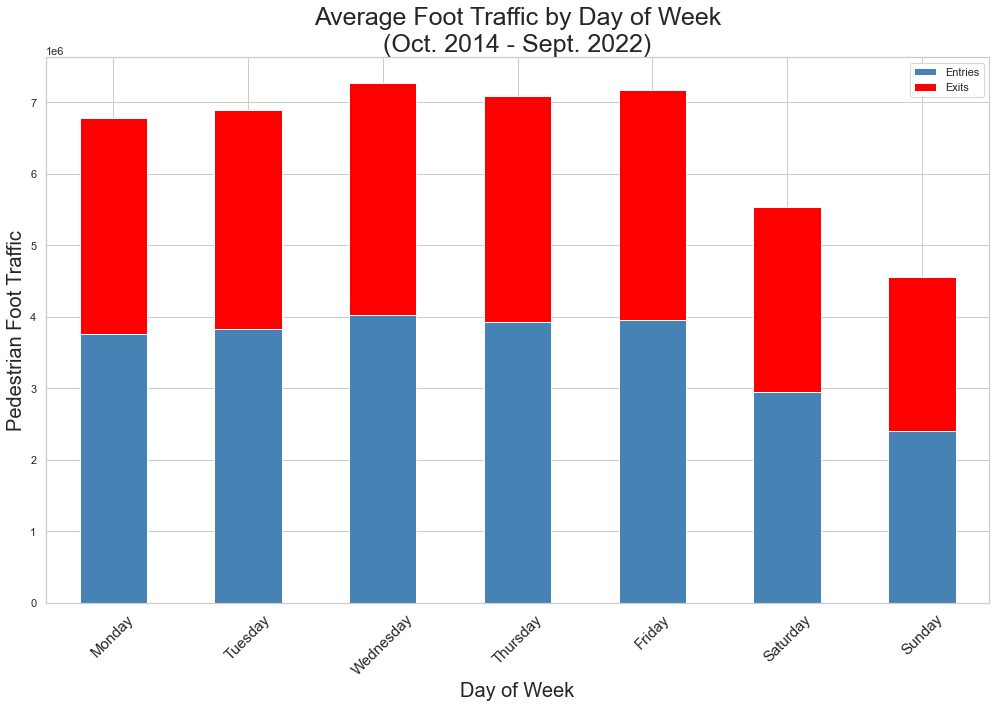

In [89]:
df_plot = mta_df[["Date", "DOW", "Entries", "Exits"]].copy()
df_plot = df_plot.groupby(["Date", "DOW"], as_index=False).sum()
df_plot = df_plot.groupby(["DOW"], as_index=False).mean().sort_values(["DOW"])
# display(df_plot)
#set seaborn plotting aesthetics
sns.set(style='whitegrid')

#create stacked bar chart
df_plot.set_index('DOW').plot(kind='bar', stacked=True, color=['steelblue', 'red'], figsize=(14,10))

plt.xticks(np.arange(0,7), np.array(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]), rotation=45, fontsize=15)
# plt.yticks(np.arange(0, 6e6, 5e6//5), np.array(["0M", "1M", "2M", "3M", "4M", "5M"]), fontsize=15)

plt.title("Average Foot Traffic by Day of Week\n(Oct. 2014 - Sept. 2022)", fontsize=25)
plt.xlabel("Day of Week", fontsize=20)
plt.ylabel("Pedestrian Foot Traffic", fontsize=20)

plt.savefig("./img/Avg_Traffic_by_DayofWeek.png", 
            dpi=150)
plt.tight_layout()

In [74]:
df_plot = mta_df[mta_df["Complex ID"] == 610][["Date", "Hour", "Traffic"]].copy()
df_plot = df_plot.groupby(["Date", "Hour"], as_index=False).sum()
df_plot = df_plot.groupby(["Hour"], as_index=False).mean()
df_plot.max()

Hour          20.000000
Traffic   213483.559322
dtype: float64

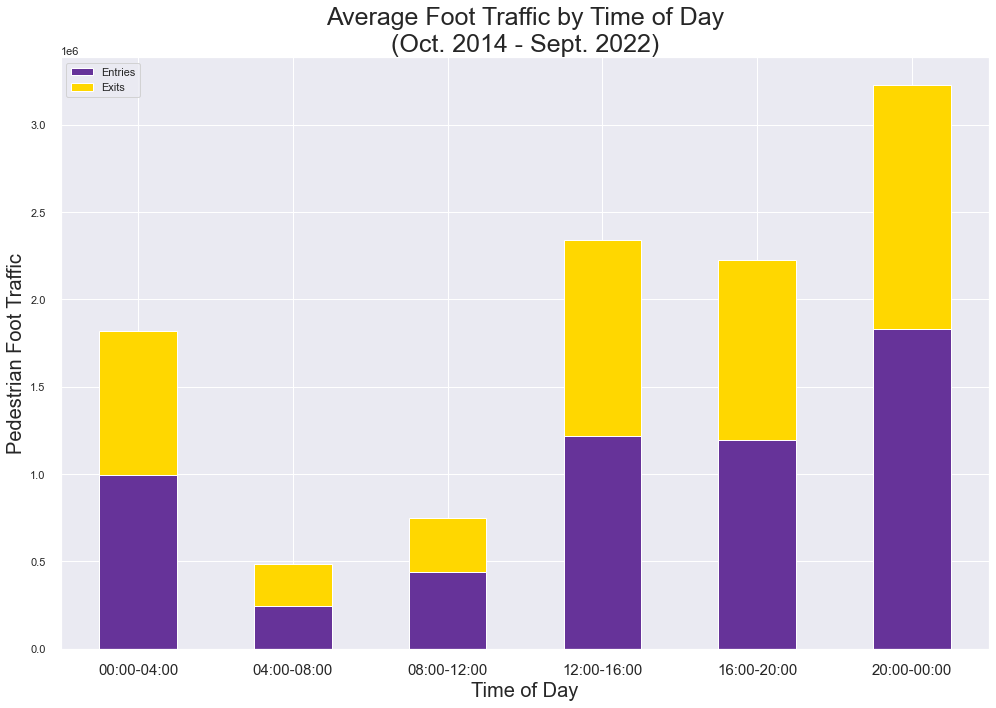

In [67]:
df_plot = mta_df[["Date", "Hour", "Entries", "Exits"]].copy()
df_plot = df_plot.groupby(["Date", "Hour"], as_index=False).sum()
df_plot = df_plot.groupby(["Hour"], as_index=False).mean()
#set seaborn plotting aesthetics
sns.set(style='darkgrid')

#create stacked bar chart
df_plot.set_index('Hour').plot(kind='bar', stacked=True, color=["rebeccapurple", "gold"], figsize=(14,10))

xtick_labels = np.array(["00:00-04:00", "04:00-08:00", "08:00-12:00", "12:00-16:00", "16:00-20:00", "20:00-00:00"])
plt.xticks(np.arange(0,6), xtick_labels, fontsize=15)
plt.xticks(rotation=0)

# plt.yticks(np.arange(0, 21e5, 2e6//8), 
#            np.array(["0", "0.25M", "0.50M", "0.75M", "1M", "1.25M", "1.50M", "1.75M", "2M"]),
#           fontsize=15)

plt.title("Average Foot Traffic by Time of Day\n(Oct. 2014 - Sept. 2022)", fontsize=25)
plt.xlabel("Time of Day", fontsize=20)
plt.ylabel("Pedestrian Foot Traffic", fontsize=20)

plt.savefig("./img/Avg_Traffic_by_TimeofDay.png", 
            dpi=150)
plt.tight_layout()

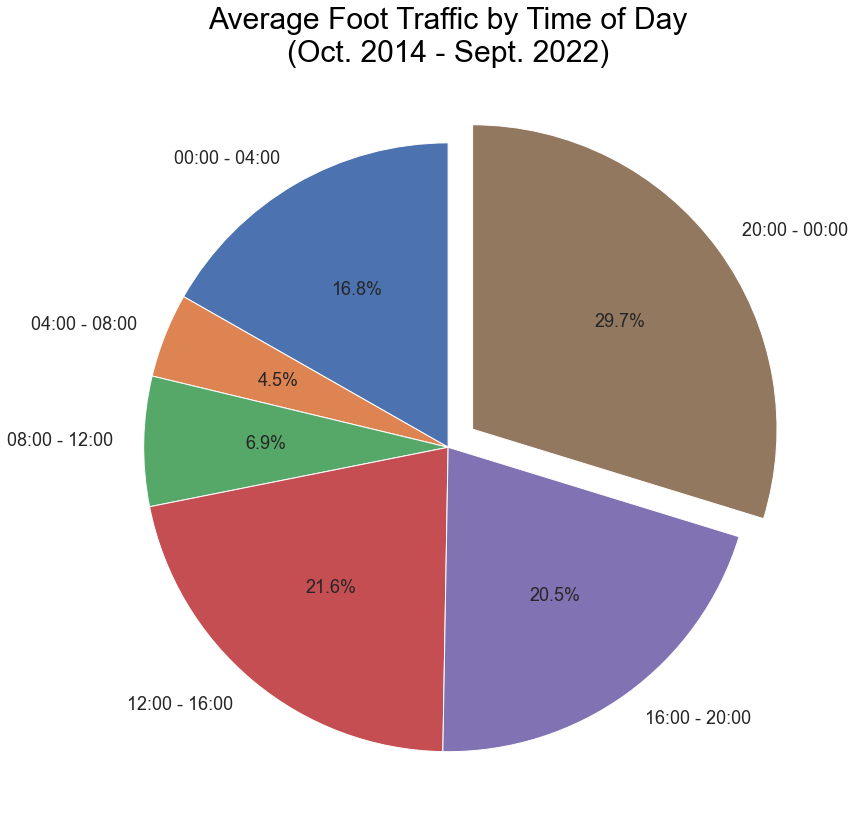

In [91]:
df_plot = mta_df[["Date", "Hour", "Traffic"]].copy()
df_plot = df_plot.groupby(["Date", "Hour"], as_index=False).sum()
df_plot = df_plot.groupby(["Hour"], as_index=False).mean()

fig1, ax1 = plt.subplots(figsize=(20,14))
time = '00:00 - 04:00', '04:00 - 08:00', '08:00 - 12:00', '12:00 - 16:00','16:00 - 20:00','20:00 - 00:00'
traffic = list(df_plot.Traffic)
explode = (0, 0, 0, 0, 0 ,0.1)  
ax1.pie(traffic, explode=explode, labels=time, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 18})
plt.title("Average Foot Traffic by Time of Day\n(Oct. 2014 - Sept. 2022)", c="black", fontsize=30)
plt.savefig("./img/Avg_Traffic_by_TimeofDay_PieChart.png", dpi=100)
plt.show()

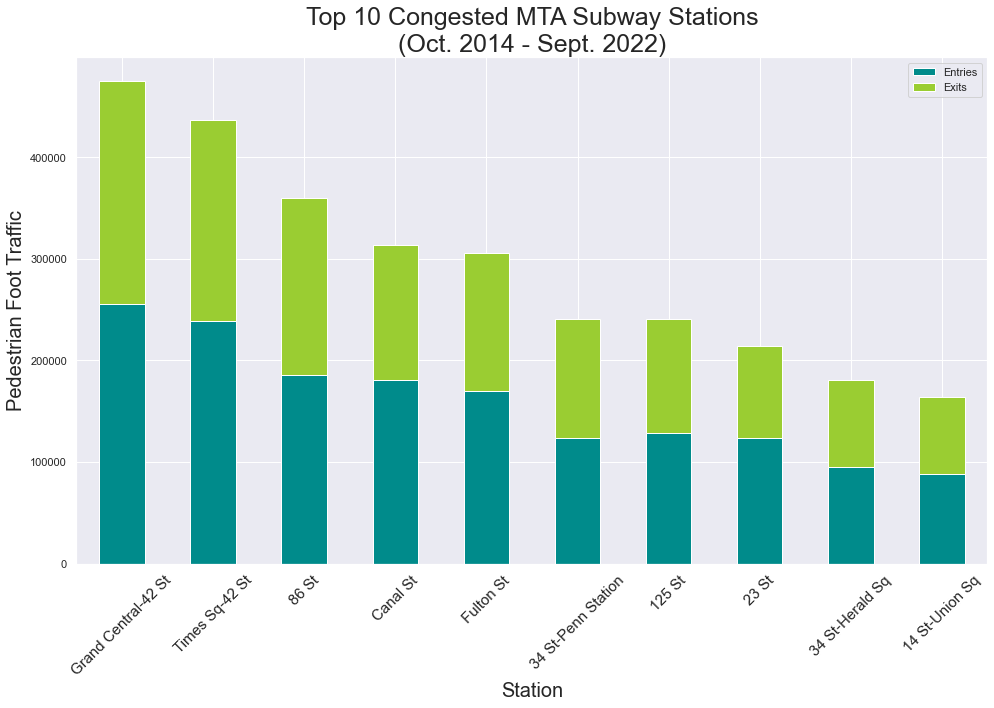

In [92]:
df_plot = mta_df[["Date", "Station", "Entries", "Exits", "Traffic"]].copy()
df_plot = df_plot.groupby(["Date", "Station"], as_index=False).sum()
df_plot = df_plot.groupby(["Station"], as_index=False).mean().sort_values(["Traffic"], ascending=False)[:10].drop(["Traffic"], axis=1)
#set seaborn plotting aesthetics
sns.set(style='darkgrid')

#create stacked bar chart
df_plot.set_index('Station').plot(kind='bar', stacked=True, color=['darkcyan', 'yellowgreen'], figsize=(14,10))

# set ticks
ytick_labels = np.array(["0", "20K", "40K", "60K", "80K", "100K", "120K", "140K", "160K"])
# plt.yticks(np.arange(0,165e3, 20e3), ytick_labels, fontsize=15)
plt.xticks(rotation=45, fontsize=15)

# set title and axis labels
plt.title("Top 10 Congested MTA Subway Stations\n(Oct. 2014 - Sept. 2022)", fontsize=25)
plt.xlabel("Station", fontsize=20)
plt.ylabel("Pedestrian Foot Traffic", fontsize=20)
plt.tight_layout()
plt.savefig("./img/Top10Stations.png", 
            dpi=150)
# plt.tight_layout()
plt.show()

In [26]:
# Grand Central-42 St

In [63]:
1.3e9
np.arange(0,1.5e9, 2e8)

array([0.0e+00, 2.0e+08, 4.0e+08, 6.0e+08, 8.0e+08, 1.0e+09, 1.2e+09,
       1.4e+09])

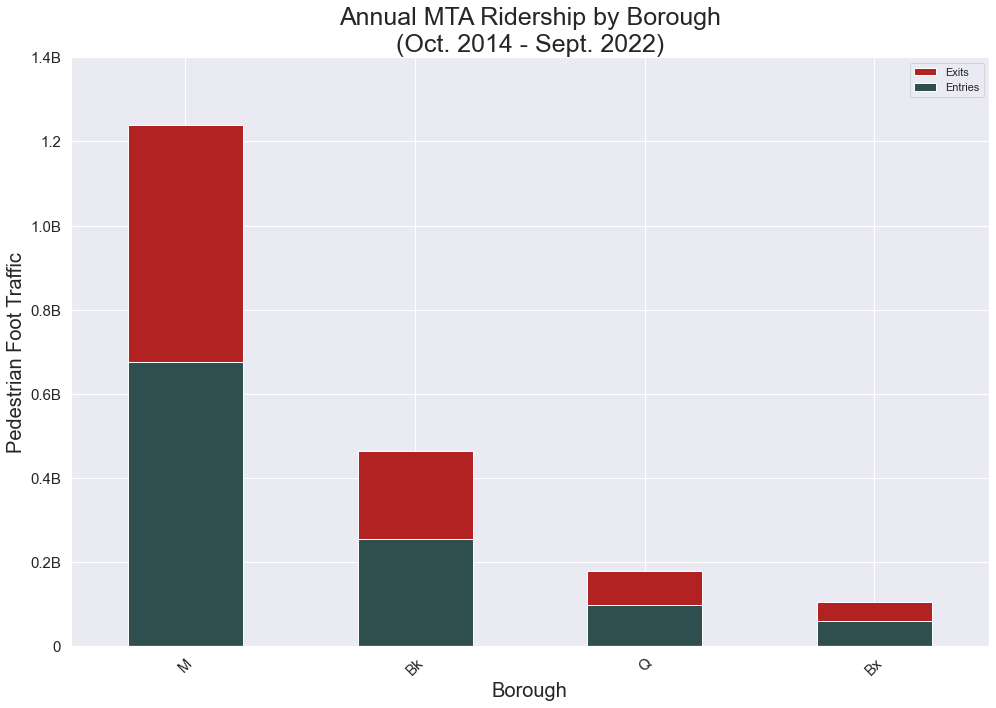

In [68]:
df_plot = mta_df[["Year", "Borough", "Entries", "Exits", "Traffic"]].copy()
df_plot = df_plot[df_plot.Borough != "SI"]
df_plot = df_plot.groupby(["Year", "Borough"], as_index=False).sum()
df_plot = df_plot.groupby(["Borough"], as_index=False).mean().sort_values(["Traffic"], ascending=False).drop(["Traffic"], axis=1)
#set seaborn plotting aesthetics
sns.set(style='darkgrid')

#create stacked bar chart
df_plot.set_index('Borough').plot(kind='bar', stacked=True, color=['firebrick', 'darkslategrey'], figsize=(14,10))

# set ticks
ytick_labels = np.array(["0", "0.2B", "0.4B", "0.6B", "0.8B", "1.0B", "1.2", "1.4B"])
plt.yticks(np.arange(0,1.5e9, 2e8), ytick_labels, fontsize=15)
plt.xticks(rotation=45, fontsize=15)

# set title and axis labels
plt.title("Annual MTA Ridership by Borough\n(Oct. 2014 - Sept. 2022)", fontsize=25)
plt.xlabel("Borough", fontsize=20)
plt.ylabel("Pedestrian Foot Traffic", fontsize=20)
plt.legend(["Exits", "Entries"])

plt.tight_layout()
plt.savefig("./img/AnnualRidershipbyBorough.png", 
            dpi=150)
plt.show()

In [42]:
mta_df.Borough.unique()

array(['M', 'Bk', 'Q', 'Bx', 'SI'], dtype=object)

In [41]:
plot_df = mta_df[mta_df.Borough != 'SI'].copy()
plot_df = plot_df.groupby(["Date", "Borough"])["Traffic"].sum().reset_index()
plot_df = plot_df.groupby(["Borough"]).mean().reset_index()
plot_df   

Borough        Traffic
0      Bk 1507526.001448
1      Bx  339241.736116
2       M 4040701.769732
3       Q  580038.625634

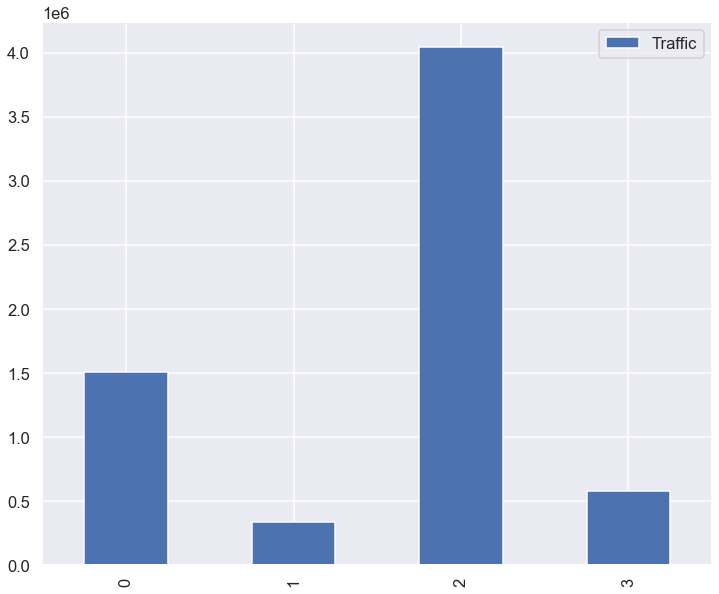

In [53]:
fig, ax = plt.subplots(figsize=(12,10))
plot_df.plot(kind="bar", ax=ax)
plt.legend()

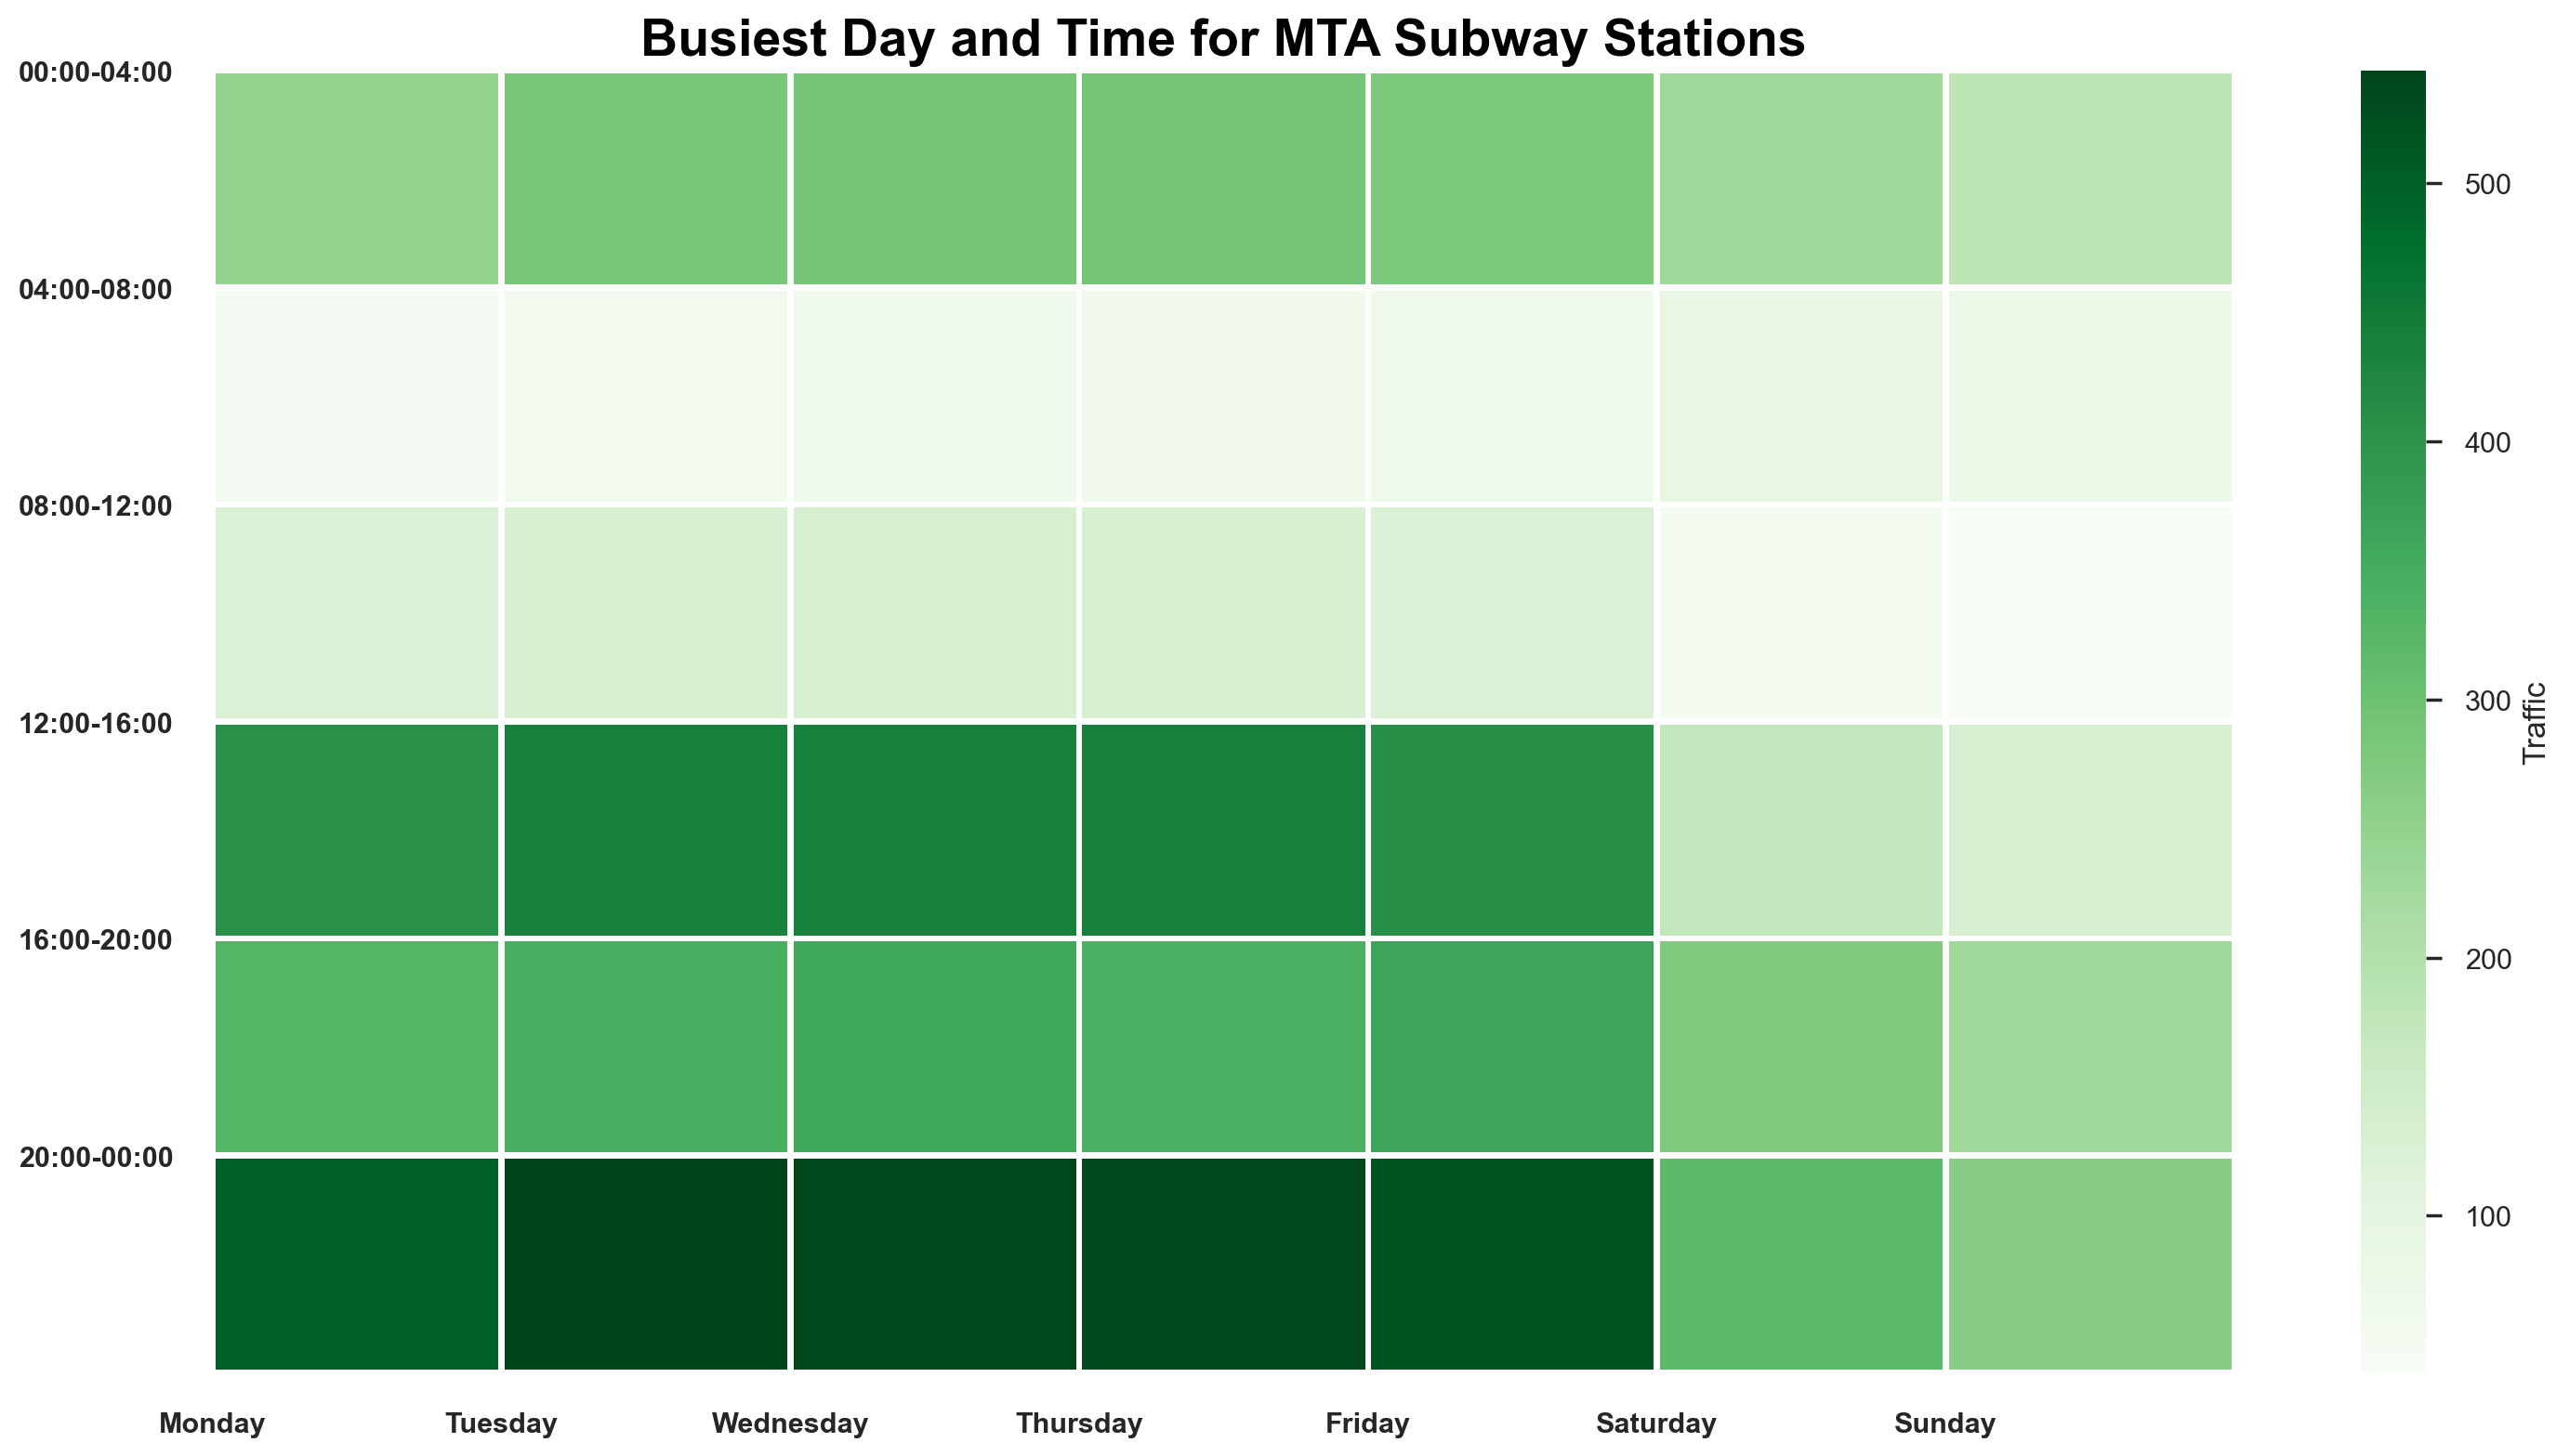

In [70]:
plot_df = mta_df[["Date", "DOW", "Station", "Hour", "Traffic"]].copy()
plot_df = plot_df.groupby(["DOW", "Hour"], as_index=False).agg("mean")

mta_top1_heatmap_detail = plot_df.pivot(index="Hour", columns="DOW",values="Traffic")
# display(mta_top1_heatmap_detail.reindex([4,8,12,16,20,0]))

#Heatmap for most congested time and day
ax, fig = plt.subplots(figsize=(15,8),dpi=200)
sns.set(font_scale=1)
#.reindex([4,8,12,16,20,0]
sns.heatmap(mta_top1_heatmap_detail,
            annot=False, 
            linewidths=2, 
            cmap="Greens",
            cbar_kws={'label': 'Traffic'})
plt.style.use('seaborn-talk')
plt.ylabel("")
plt.xlabel("")
plt.yticks(weight="bold",rotation=0)
plt.yticks([0,1,2,3,4,5],["00:00-04:00", "04:00-08:00", "08:00-12:00", "12:00-16:00", "16:00-20:00", "20:00-00:00"])
plt.xticks(weight="bold",rotation=0)
plt.xticks([0,1,2,3,4,5,6], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Busiest Day and Time for MTA Subway Stations",weight="bold",c="Black", fontsize=20)
# ax.xaxis.get_majorticklabels()[2].set_x(-.5)

plt.tight_layout()

# save image as PNG file
plt.savefig("./img/BusiestDayTimeTraffic_Oct2014_Sept2022).png", dpi=200)
plt.show()

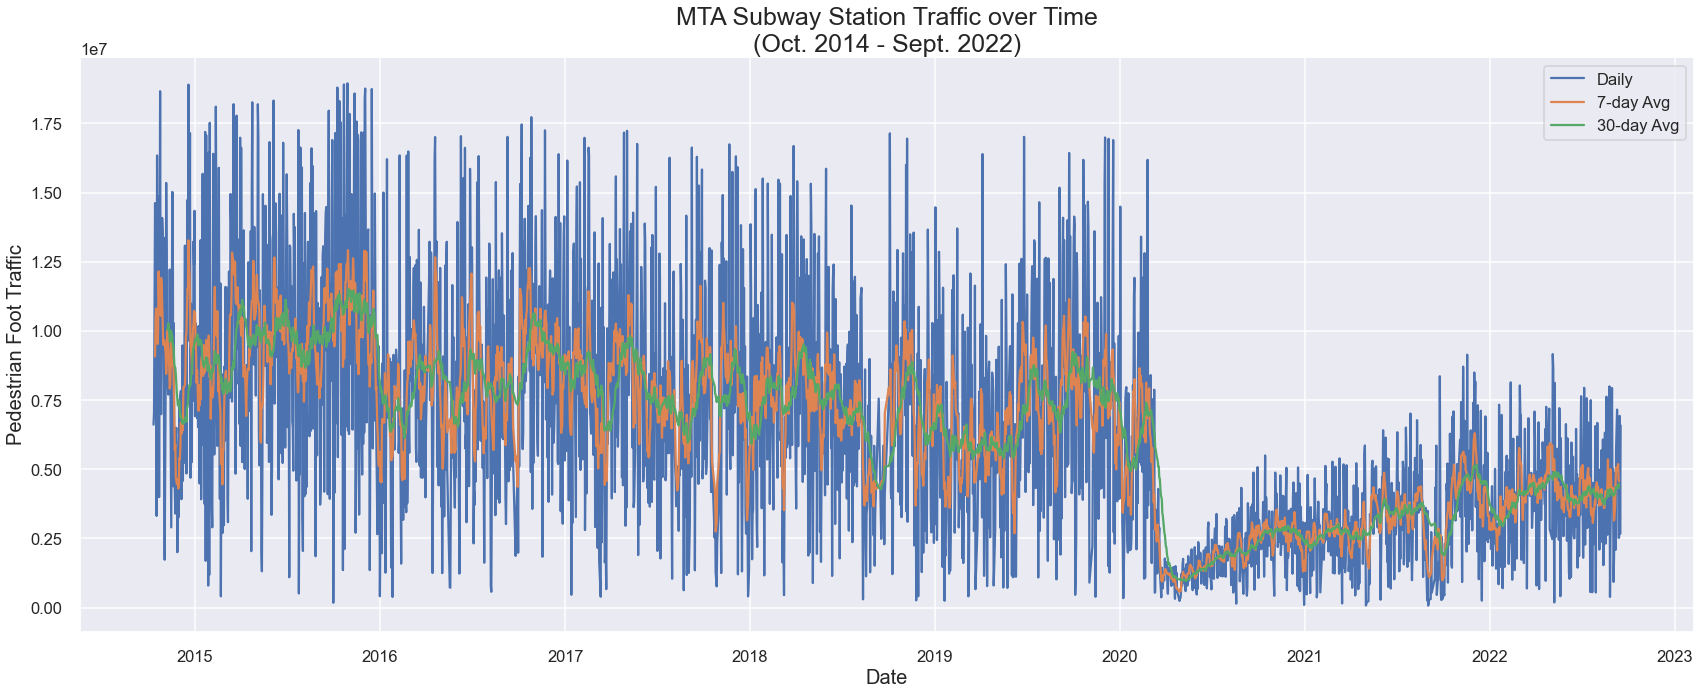

In [71]:
# Copy Data
df_plot = mta_df[["Date", "Traffic"]].copy()
# Group by day and aggregate the sum
df_plot = df_plot.groupby(["Date"], as_index=False).sum()
# Create 7-day rolling average for Traffic
df_plot['Traffic_7day_ave'] = df_plot.Traffic.rolling(7).mean().shift(-3)
# Create 7-day rolling average for Traffic
df_plot['Traffic_30day_ave'] = df_plot.Traffic.rolling(30).mean().shift(-3)

# bigger plot elements suitable for giving talks
sns.set_context("talk")

# set figure size
plt.figure(figsize=(24,10))
# Line Plot displaying Daily Traffic
sns.lineplot(x="Date", y="Traffic",
             label="Daily", 
             data=df_plot,
             ci=None)
# Line Plot displaying 7day rolling average Traffic
sns.lineplot(x="Date" ,y="Traffic_7day_ave",
             label="7-day Avg",
             data=df_plot,
             ci=None)
# Line Plot displaying 30day rolling average Traffic
sns.lineplot(x="Date" ,y="Traffic_30day_ave",
             label="30-day Avg",
             data=df_plot,
             ci=None)
# set axis labels
plt.xlabel("Date", size=20)
plt.ylabel("Pedestrian Foot Traffic", size=20)
# set yticks
# yticks = np.arange(0, 14e6, 2e6)
# yticks_label = np.array(["2M", "4M", "6M", "8M", "10M", "12M", "14M"])
# plt.yticks(yticks, yticks_label)
# set Plot title
plt.title("MTA Subway Station Traffic over Time\n(Oct. 2014 - Sept. 2022)", fontsize=25)

# save image as PNG file
plt.savefig("./img/daily7day30day_average_Traffic_Oct2014_Sept2022).png",
                    format='png',
                    dpi=150)

# Display Image
plt.tight_layout()
plt.show()

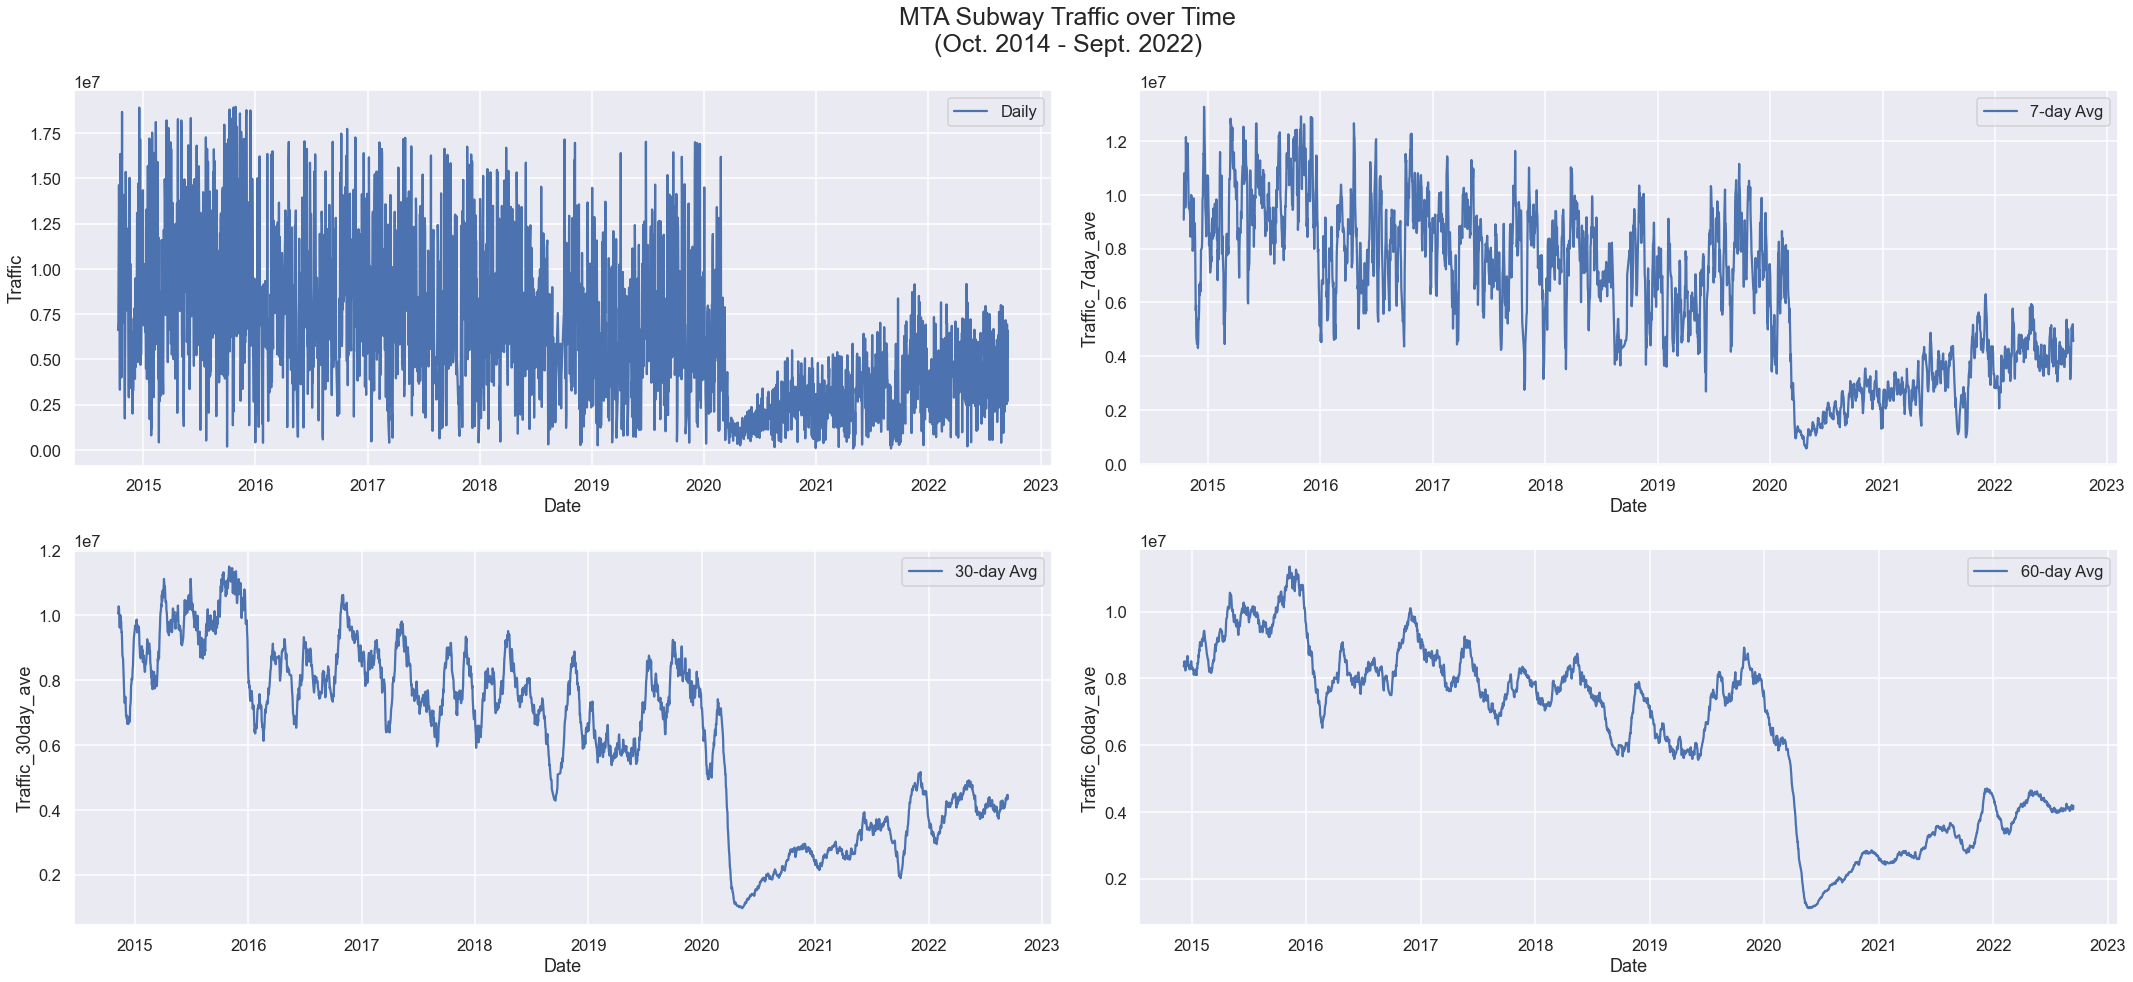

In [46]:
# Copy Data
df_plot = mta_df[["Date", "Traffic"]].copy()
# Group by day and aggregate the sum
df_plot = df_plot.groupby(["Date"], as_index=False).sum()
# Create 7-day rolling average for Traffic
df_plot['Traffic_7day_ave'] = df_plot.Traffic.rolling(7).mean().shift(-3)
# Create 30-day rolling average for Traffic
df_plot['Traffic_30day_ave'] = df_plot.Traffic.rolling(30).mean().shift(-3)
# Create 60-day rolling average for Traffic
df_plot['Traffic_60day_ave'] = df_plot.Traffic.rolling(60).mean().shift(-3)

# bigger plot elements suitable for giving talks
sns.set_context("talk")

# set figure size
fig, axes = plt.subplots(2,2,figsize=(30,14))
# Line Plot displaying Daily Traffic
sns.lineplot(x="Date", y="Traffic",
             label="Daily", 
             data=df_plot,
             ci=None,
             ax=axes[0,0])
# Line Plot displaying 7day rolling average Traffic
sns.lineplot(x="Date" ,y="Traffic_7day_ave",
             label="7-day Avg",
             data=df_plot,
             ci=None,
             ax=axes[0,1])
# Line Plot displaying 30day rolling average Traffic
sns.lineplot(x="Date" ,y="Traffic_30day_ave",
             label="30-day Avg",
             data=df_plot,
             ci=None,
             ax=axes[1,0])
# Line Plot displaying 60day rolling average Traffic
sns.lineplot(x="Date" ,y="Traffic_60day_ave",
             label="60-day Avg",
             data=df_plot,
             ci=None,
             ax=axes[1,1])
# set axis labels
# axes[0,0].set_xlabel("Date", size=20)
# axes[0,0].set_ylabel("Pedestrian Foot Traffic", size=20)
# set yticks
# yticks = np.arange(0, 14e6, 2e6)
# yticks_label = np.array(["2M", "4M", "6M", "8M", "10M", "12M", "14M"])
# j = 0
# for i in range(2):
#     for j in range(2):
#         axes[i,j].set_yticks(yticks)
#         axes[i,j].set_yticklabels(yticks_label)
#         axes[i,j].set_xlabel("Date", size=20)
#         axes[i,j].set_ylabel("Foot Traffic", size=20)
    
# set Plot title
fig.suptitle("MTA Subway Traffic over Time\n(Oct. 2014 - Sept. 2022)", fontsize=25)

# save image as PNG file
plt.savefig("./img/daily7day30day_average_Traffic_Oct2014_Sept2022).png",
                    format='png',
                    dpi=150)

# Display Image
plt.tight_layout()
plt.show()

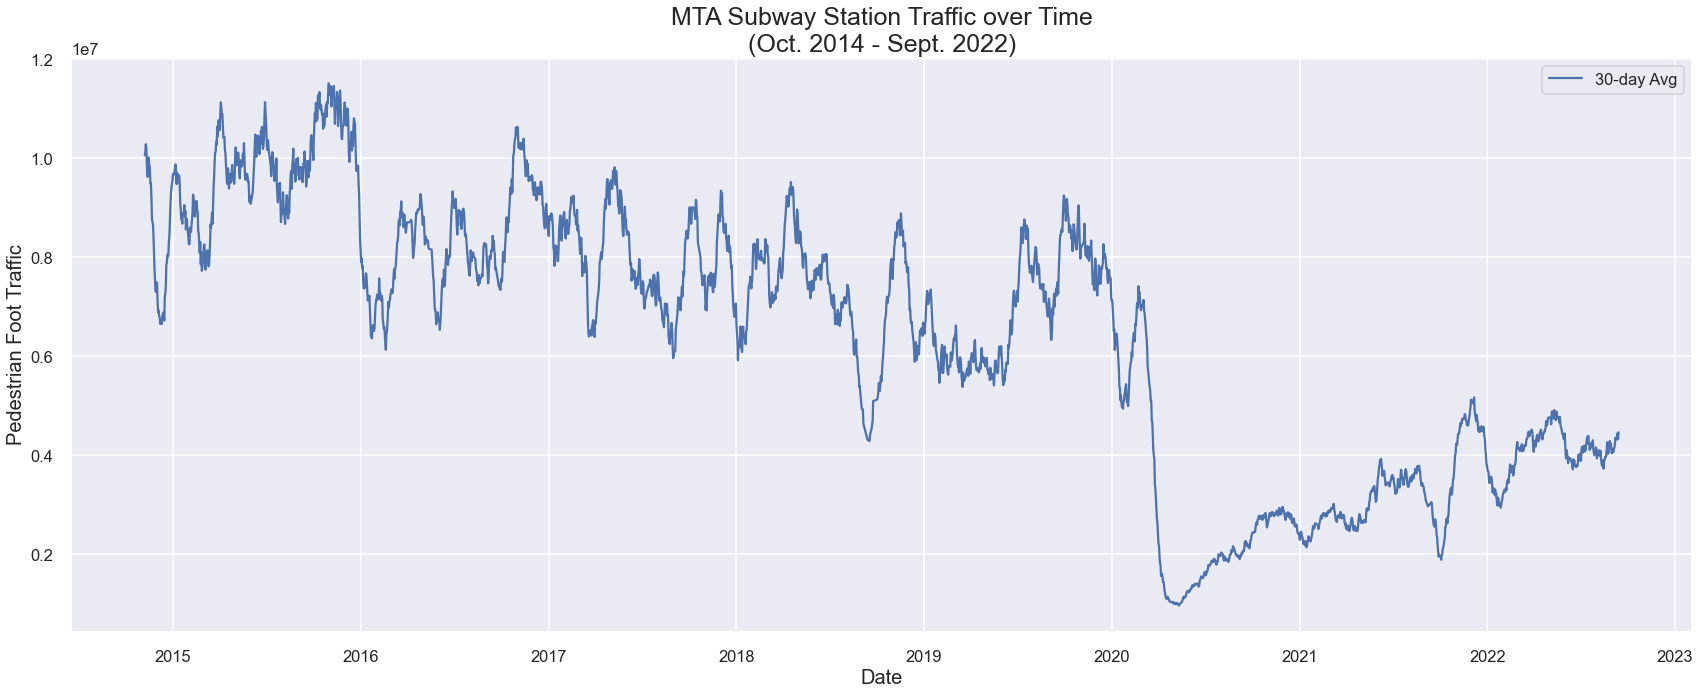

In [73]:
# Copy Data
df_plot = mta_df[["Date", "Traffic"]].copy()
# Group by day and aggregate the sum
df_plot = df_plot.groupby(["Date"], as_index=False).sum()
# Create 30-day rolling average for Traffic
df_plot['Traffic_30day_ave'] = df_plot.Traffic.rolling(30).mean().shift(-3)

# bigger plot elements suitable for giving talks
sns.set_context("talk")

# set figure size
plt.figure(figsize=(24,10))
# Line Plot displaying Daily Traffic
# sns.lineplot(x="Date", y="Traffic",
#              label="Daily", 
#              data=df_plot,
#              ci=None)
# Line Plot displaying 7day rolling average Traffic
sns.lineplot(x="Date" ,y="Traffic_30day_ave",
             label="30-day Avg",
             data=df_plot,
             ci=None)
# set axis labels
plt.xlabel("Date", size=20)
plt.ylabel("Pedestrian Foot Traffic", size=20)
# set Plot title
plt.title("MTA Subway Station Traffic over Time\n(Oct. 2014 - Sept. 2022)", fontsize=25)

# save image as PNG file
plt.savefig("./img/30day_average_Traffic_Oct2014_Sept2022.png", dpi=150)

# Display Image
plt.tight_layout()
plt.show()

In [120]:
def make_space_above(axes, topmargin=1):
    """ increase figure size to make topmargin (in inches) space for 
        titles, without changing the axes sizes"""
    fig = axes.flatten()[0].figure
    s = fig.subplotpars
    w, h = fig.get_size_inches()

    figh = h - (1-s.top)*h  + topmargin
    fig.subplots_adjust(bottom=s.bottom*h/figh, top=1-topmargin/figh)
    fig.set_figheight(figh)

2014

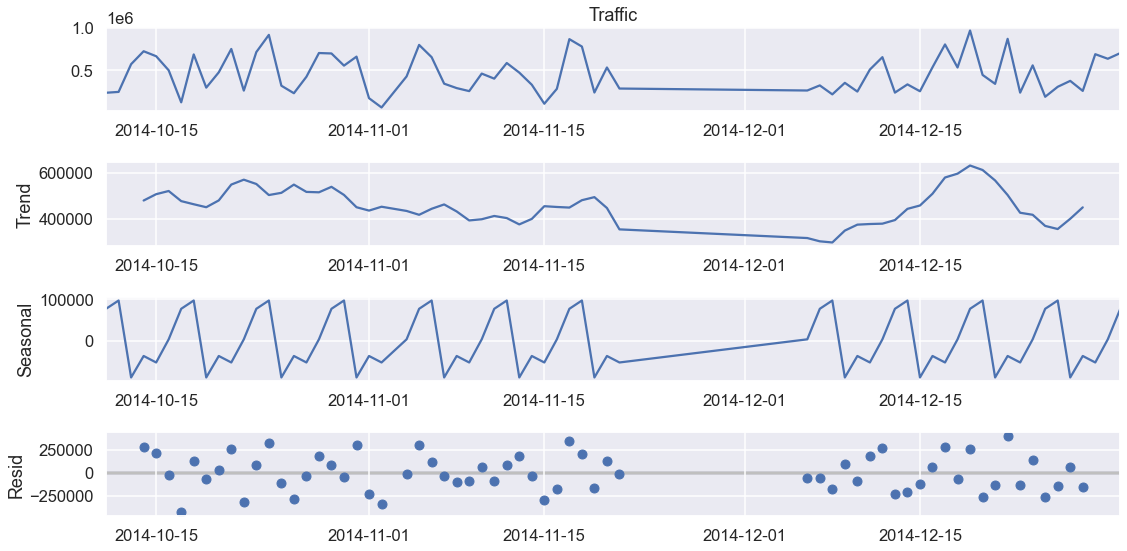

2015

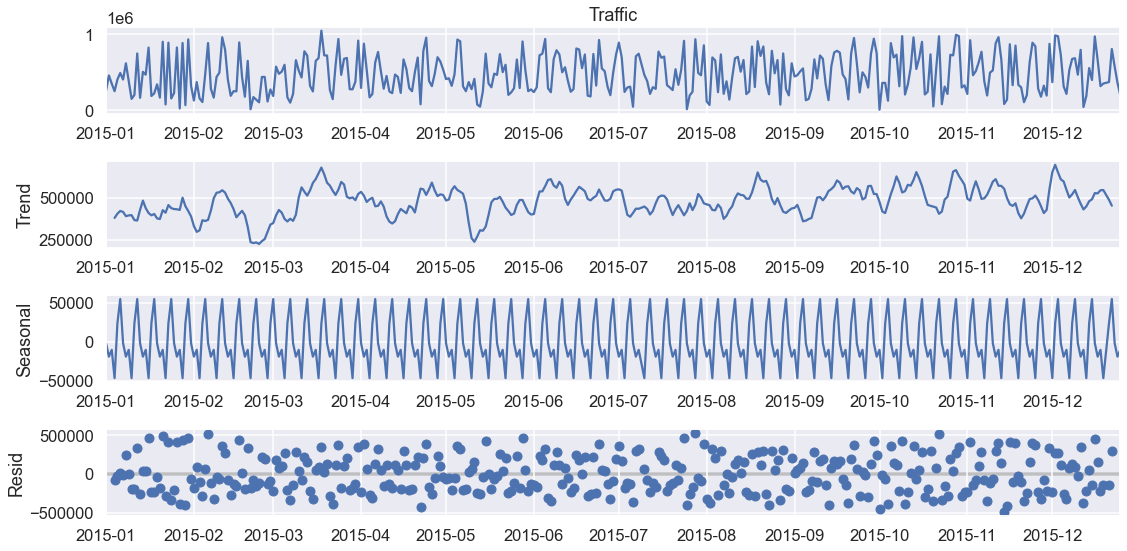

In [31]:
#set seaborn plotting aesthetics
# sns.set(style='darkgrid')
# bigger plot elements suitable for giving talks
sns.set_context("talk")
# Copy Data
df_plot = mta_df[["Date", "Year", "Complex ID", "Traffic"]].copy()
# Group by day and aggregate the sum
df_plot = df_plot.groupby(["Date", "Year", "Complex ID"], as_index=False).sum()
# Create 30-day rolling average for Traffic
df_plot['Traffic_30day_ave'] = df_plot.Traffic.rolling(30).mean().shift(-3)
df_plot = df_plot[df_plot["Complex ID"] == 610]
# display(df_plot)



for group_name, group in df_plot.groupby(["Year"], as_index=False)[["Date", "Traffic"]]:
    # temp_plot = group.groupby([]).sum()[["Traffic"]]
    display(group_name)
    # display(group)
    ts = group.groupby("Date").sum()["Traffic"]
    # Create 30-day rolling average for Traffic
    # ts['Traffic_30day_ave'] = ts.Traffic.rolling(30).mean().shift(-3).dropna()
    # ts = df_plot.set_index("Date")["Traffic_30day_ave"].fillna(0.0)
    # Change default figsize
    plt.rc("figure",figsize=(16,8))

    decomp_results = seasonal_decompose(ts, model='additive', period=6)
    decomp_results.plot()

    # Tight layout to realign things
    plt.tight_layout()
    plt.savefig("./img/SeasonalDecomp"+str(group_name)+"_GrandCentral.png", dpi=100) 
    plt.show()

2014

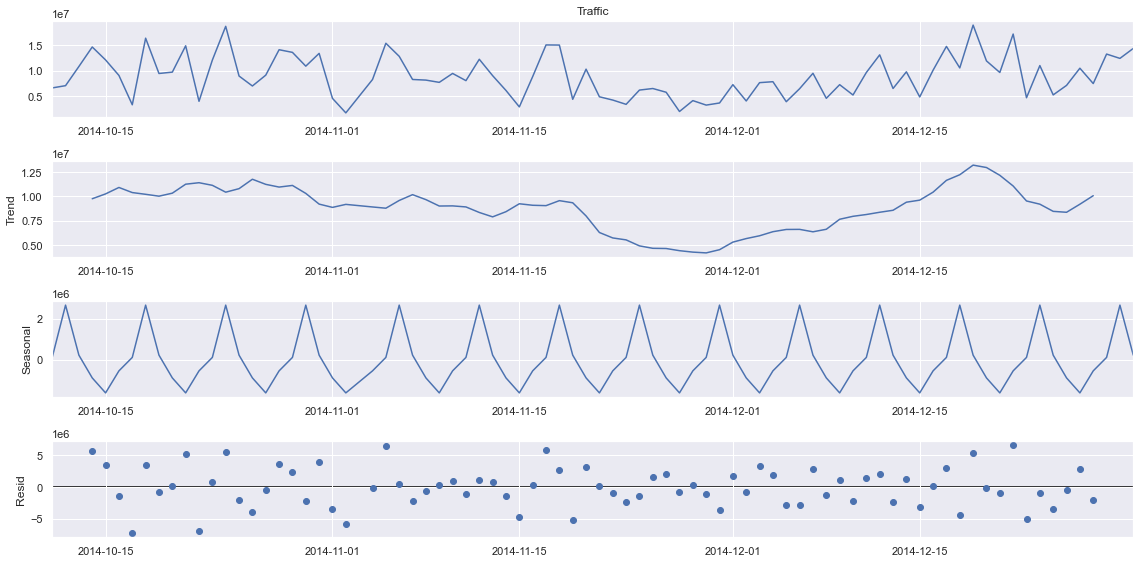

2015

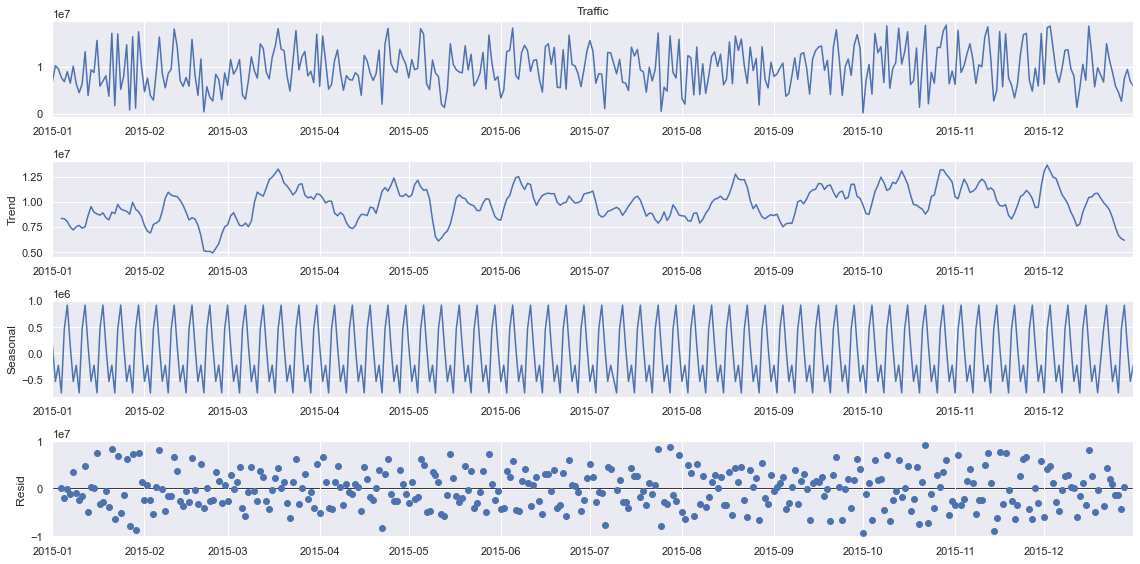

2016

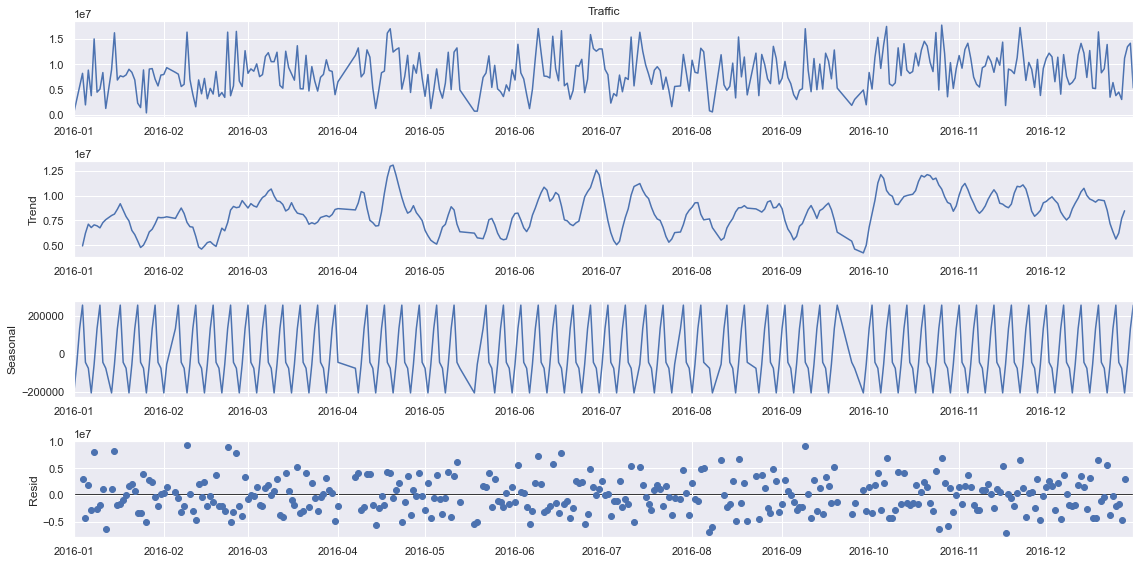

2017

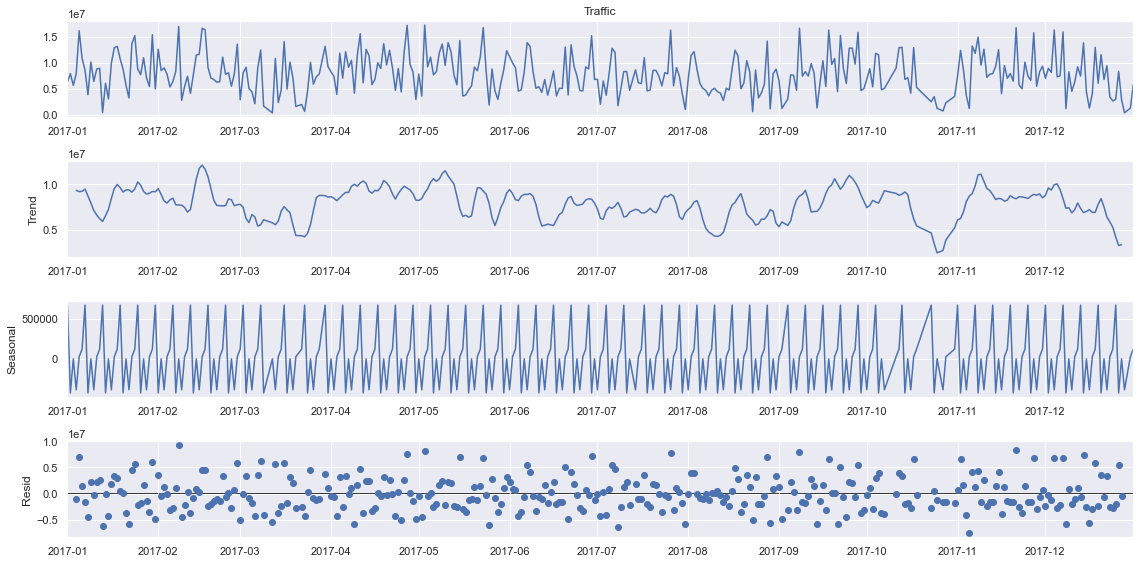

2018

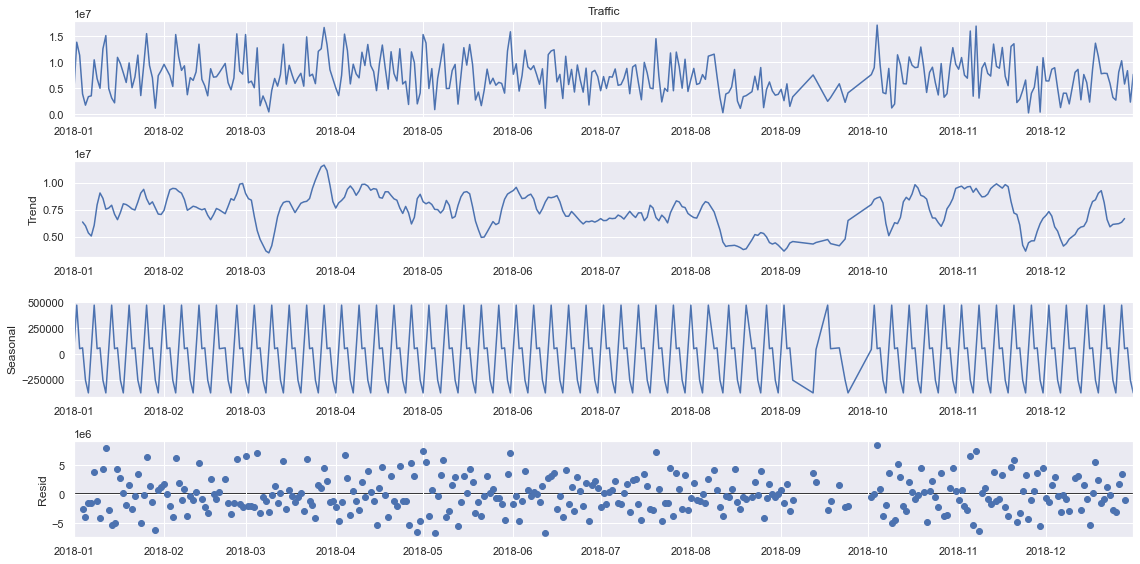

2019

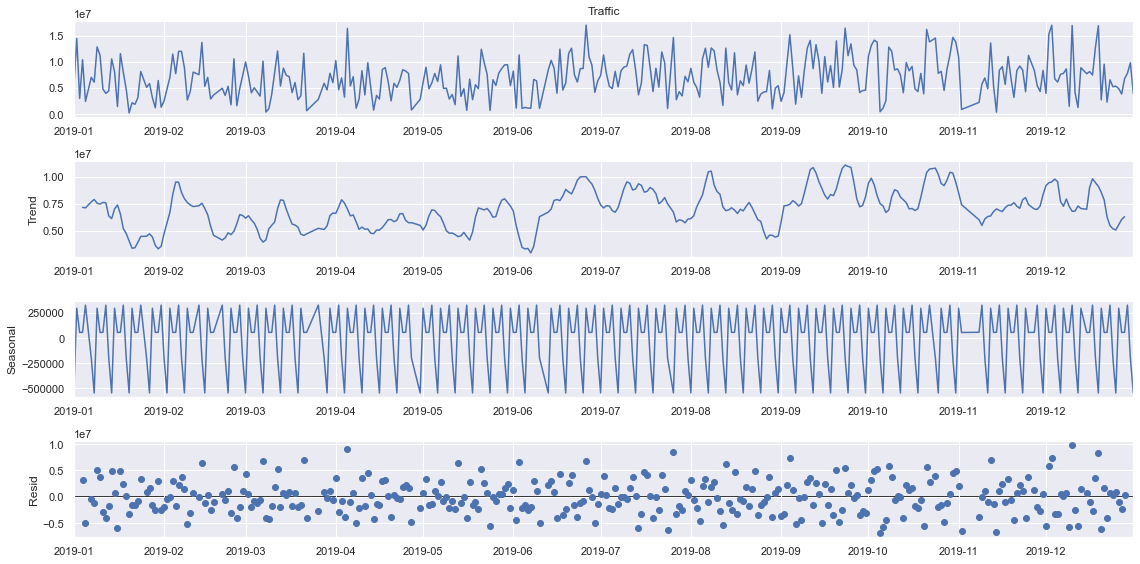

2020

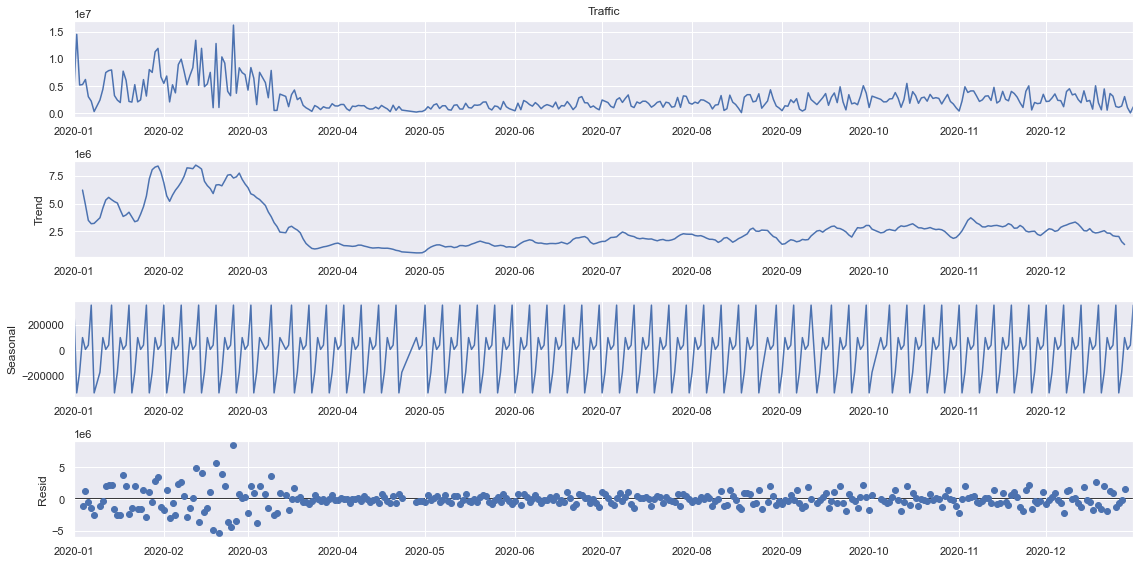

2021

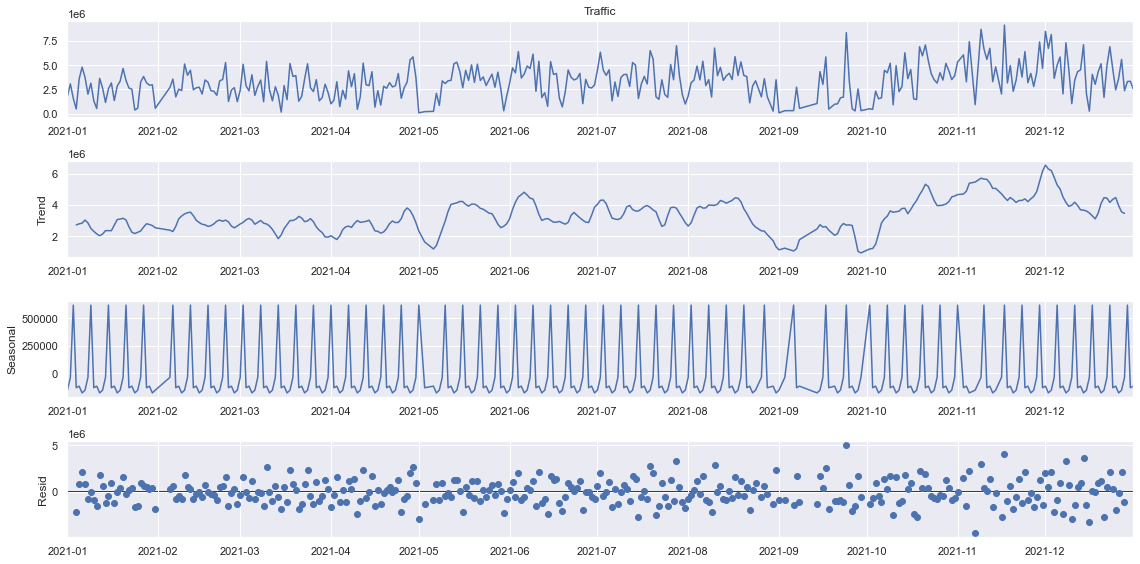

2022

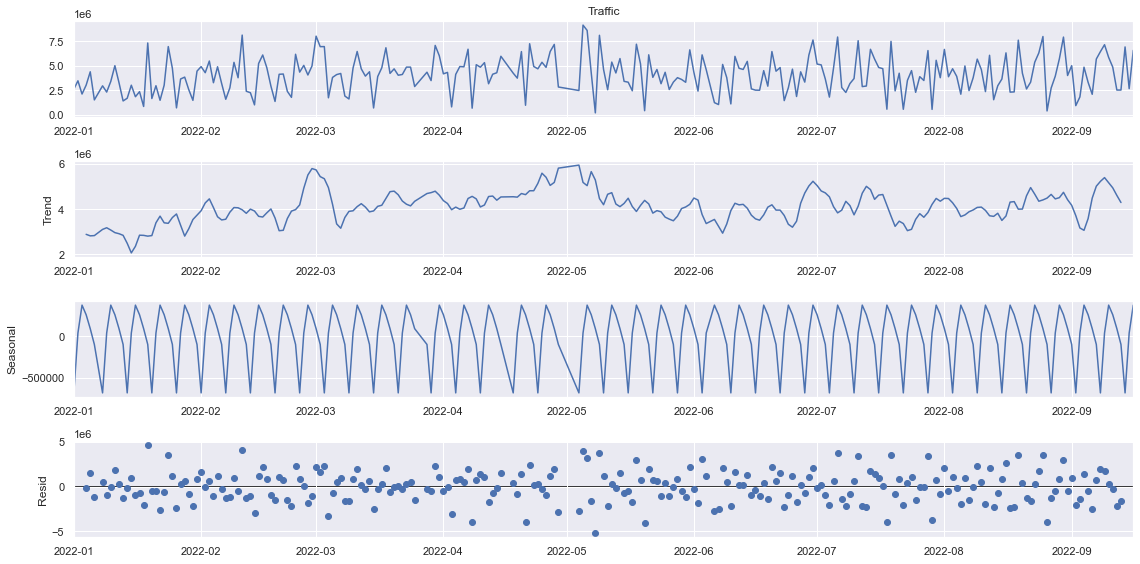

In [20]:
#set seaborn plotting aesthetics
# sns.set(style='darkgrid')
# bigger plot elements suitable for giving talks
sns.set_context("talk")
# Copy Data
df_plot = mta_df[["Date", "Year", "Traffic"]].copy()
# Group by day and aggregate the sum
df_plot = df_plot.groupby(["Date", "Year"], as_index=False).sum()
# Create 30-day rolling average for Traffic
df_plot['Traffic_30day_ave'] = df_plot.Traffic.rolling(30).mean().shift(-3)
# display(df_plot)



for group_name, group in df_plot.groupby(["Year"], as_index=False)[["Date", "Traffic"]]:
    # temp_plot = group.groupby([]).sum()[["Traffic"]]
    display(group_name)
    # display(group)
    ts = group.groupby("Date").sum()["Traffic"]
    # Create 30-day rolling average for Traffic
    # ts['Traffic_30day_ave'] = ts.Traffic.rolling(30).mean().shift(-3).dropna()
    # ts = df_plot.set_index("Date")["Traffic_30day_ave"].fillna(0.0)
    # Change default figsize
    plt.rc("figure",figsize=(16,8))

    decomp_results = seasonal_decompose(ts, model='additive', period=6)
    decomp_results.plot()

    # Tight layout to realign things
    plt.tight_layout()
    plt.savefig("./img/SeasonalDecomp"+str(group_name)+".png", dpi=100) 
    plt.show()

## Breakdown by Fiscal Year

In [66]:
# Re-copy Original Cleaned DataFrame
mta_df = master_df.copy()
# Develop "Fiscal Year" feature
mta_df['Fiscal Year'] = 2010
for y in range(2014, 2022):
    mta_df.loc[mta_df["Date"].index.to_series().between(str(y)+'-10-01', str(y+1)+'-10-01'), "Fiscal Year"] = y+1
mta_df = mta_df[["Date", "Fiscal Year", "DOW", "Year", "Month", "Day", "Hour", "Station", "Turnstile_ID", "Entries", "Exits", "Traffic"]]
# Display
mta_df

Date  Fiscal Year  DOW  Year  Month  Day  Hour  \
2014-10-11 00:00:00 2014-10-11         2015    5  2014     10   11     0   
2014-10-11 04:00:00 2014-10-11         2015    5  2014     10   11     4   
2014-10-11 08:00:00 2014-10-11         2015    5  2014     10   11     8   
2014-10-11 12:00:00 2014-10-11         2015    5  2014     10   11    12   
2014-10-11 20:00:00 2014-10-11         2015    5  2014     10   11    20   
...                        ...          ...  ...   ...    ...  ...   ...   
2022-09-16 04:00:00 2022-09-16         2022    4  2022      9   16     4   
2022-09-16 08:00:00 2022-09-16         2022    4  2022      9   16     8   
2022-09-16 12:00:00 2022-09-16         2022    4  2022      9   16    12   
2022-09-16 16:00:00 2022-09-16         2022    4  2022      9   16    16   
2022-09-16 00:00:00 2022-09-16         2022    4  2022      9   16     0   

                           Station         Turnstile_ID  Entries  Exits  \
2014-10-11 00:00:00  LEXINGTON AVE   A002-R051-02-00-00        0      0   
2014-10-11 04:00:00  LEXINGTON AVE   A002-R051-02-00-00       45      4   
2014-10-11 08:00:00  LEXINGTON AVE   A002-R051-02-00-00       16     30   
2014-10-11 12:00:00  LEXINGTON AVE   A002-R051-02-00-00       96    104   
2014-10-11 20:00:00  LEXINGTON AVE   A002-R051-02-00-00      363     48   
...                            ...                  ...      ...    ...   
2022-09-16 04:00:00  RIT-ROOSEVELT  TRAM2-R469-00-05-01        0      0   
2022-09-16 08:00:00  RIT-ROOSEVELT  TRAM2-R469-00-05-01        0      0   
2022-09-16 12:00:00  RIT-ROOSEVELT  TRAM2-R469-00-05-01        0      0   
2022-09-16 16:00:00  RIT-ROOSEVELT  TRAM2-R469-00-05-01        0      0   
2022-09-16 00:00:00  RIT-ROOSEVELT  TRAM2-R469-00-05-01        0      0   

                     Traffic  
2014-10-11 00:00:00        0  
2014-10-11 04:00:00       49  
2014-10-11 08:00:00       46  
2014-10-11 12:00:00      200  
2014-10-11 20:00:00      411  
...                      ...  
2022-09-16 04:00:00        0  
2022-09-16 08:00:00        0  
2022-09-16 12:00:00        0  
2022-09-16 16:00:00        0  
2022-09-16 00:00:00        0  

[51582941 rows x 12 columns]

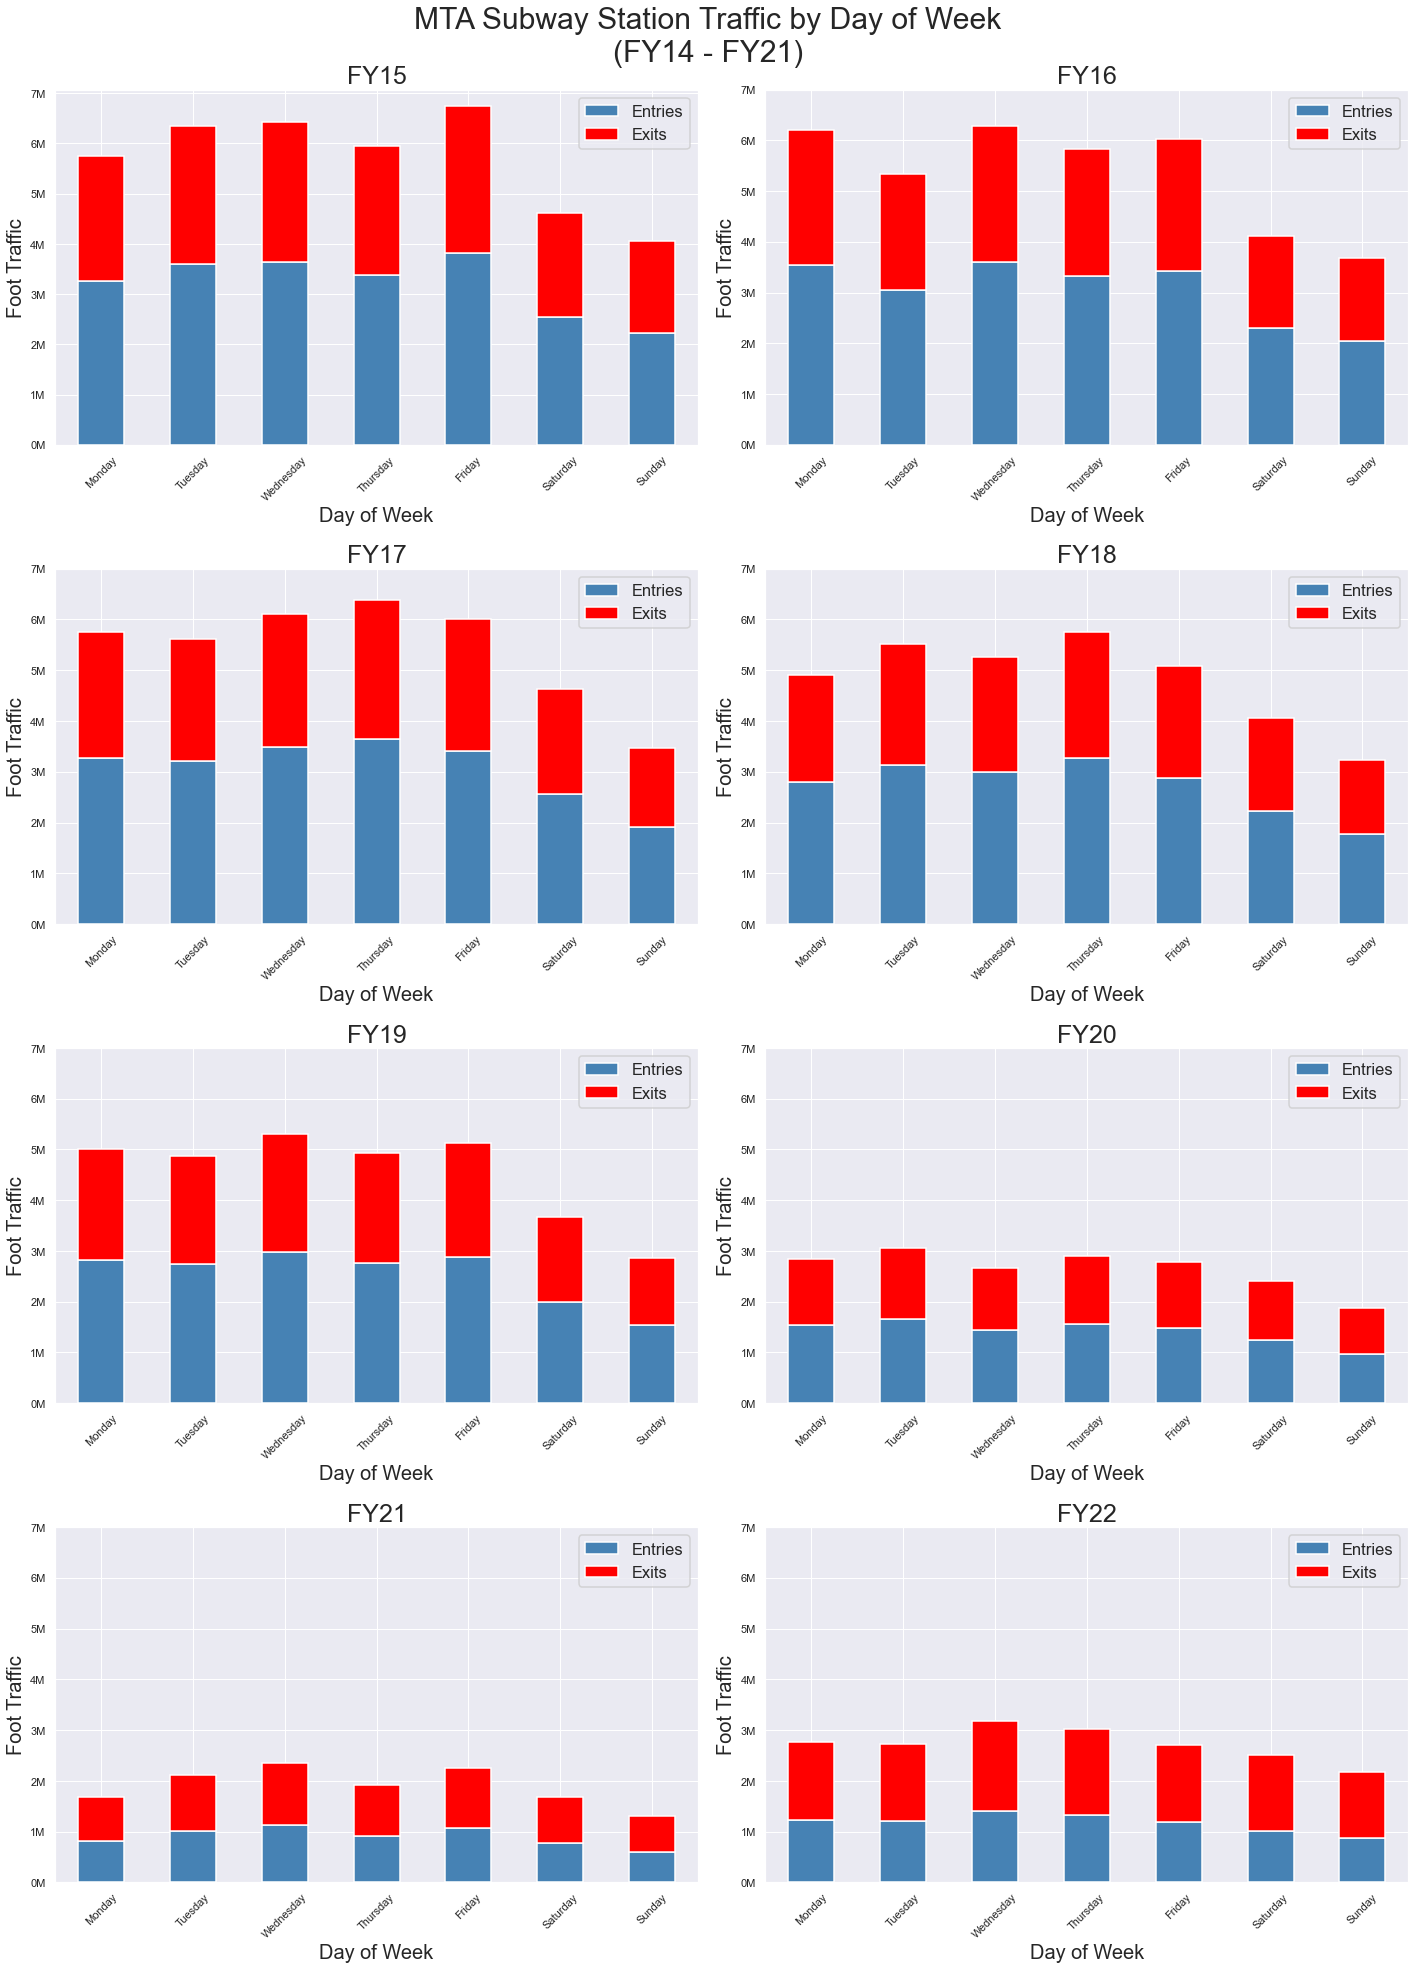

In [86]:
'''
Take a closer look at the average by the day of week over the years
Note: Broken up by U.S. Federal Fiscal Year Calendar
'''

fig, axes = plt.subplots(4,2, figsize=(20,28))

# Copy Data
df_plot = mta_df[["Date", "Fiscal Year", "DOW", "Entries", "Exits"]].copy()
# Group by day, year, DOW and aggregate the sum
df_plot = df_plot.groupby(["Date", "Fiscal Year", "DOW"], as_index=False).sum()
# Group by Fiscal Year and DOW and take the DOW mean
df_plot = df_plot.groupby(["Fiscal Year", "DOW"], as_index=False).mean().sort_values(["DOW"])

# bigger plot elements suitable for giving talks
sns.set_context("talk")

# Set axes indices
i = 0
j = 0
# Loop over years
for year in range(2015,2023):
    # Filter by FY
    # create stacked bar chart
    df_plot[df_plot["Fiscal Year"] == year].set_index("DOW").drop("Fiscal Year", axis=1).plot(kind="bar", stacked=True, color=["steelblue", "red"], ax=axes[i,j])
    # set axes ticks
    axes[i,j].set_xticks(np.arange(0,7))
    axes[i,j].set_xticklabels(np.array(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]),
                              rotation=45)
    axes[i,j].set_yticks(np.arange(0, 8e6, 8e6//8))
    axes[i,j].set_yticklabels(np.array(["0M", "1M", "2M", "3M", "4M", "5M", "6M", "7M"]))
    # set axes title's and labels
    axes[i,j].set_title("FY{}".format(year-2000), fontsize=25)
    axes[i,j].set_xlabel("Day of Week", fontsize=20)
    axes[i,j].set_ylabel("Foot Traffic", fontsize=20)
    # Perform index manipulation 
    if j < 1:
        j += 1
    else:
        i += 1
        j = 0
# set fig suptitle
fig.suptitle("MTA Subway Station Traffic by Day of Week\n(FY14 - FY21)", fontsize=30)

# save image as PNG file
plt.savefig("./img/FiscalYearly_Avg_Traffic_by_DayofWeek.png", 
            dpi=150)

#display figure
plt.tight_layout()
plt.show()

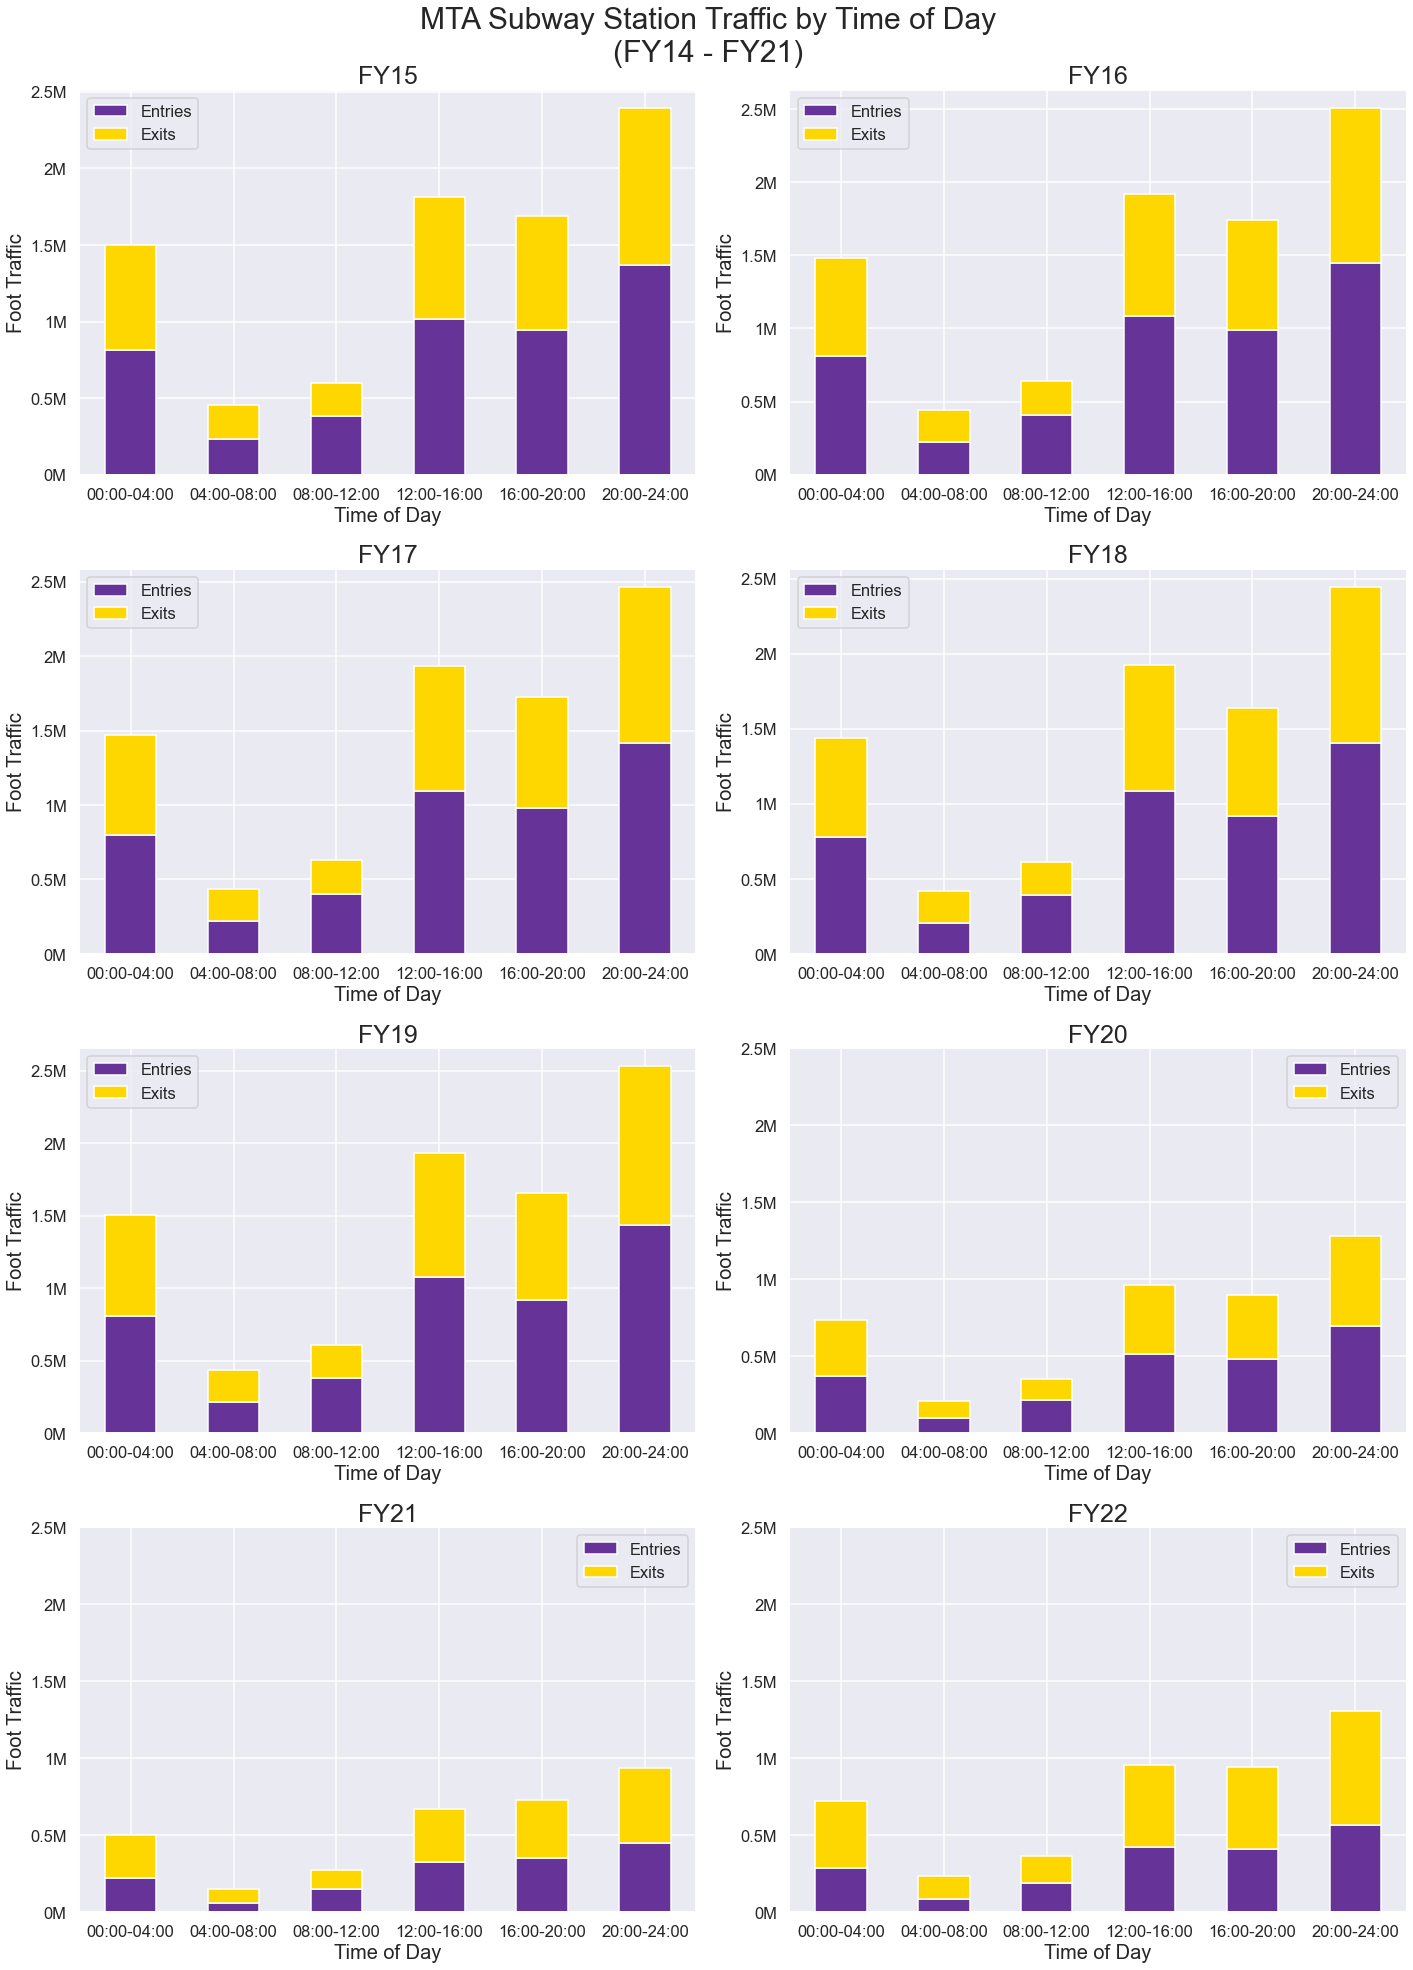

In [97]:
'''
Take a closer look at the average by the day of week over the years
Note: Broken up by U.S. Federal Fiscal Year Calendar
'''

fig, axes = plt.subplots(4,2, figsize=(20,28))

# Copy Data
df_plot = mta_df[["Date", "Fiscal Year", "Hour", "Entries", "Exits"]].copy()
# Group by day, year, DOW and aggregate the sum
df_plot = df_plot.groupby(["Date", "Fiscal Year", "Hour"], as_index=False).sum()
# Group by Fiscal Year and DOW and take the DOW mean
df_plot = df_plot.groupby(["Fiscal Year", "Hour"], as_index=False).mean()

# bigger plot elements suitable for giving talks
sns.set_context("talk")

# tick labels
xtick_labels = np.array(["00:00-04:00", "04:00-08:00", "08:00-12:00", "12:00-16:00", "16:00-20:00", "20:00-24:00"])

# Set axes indices
i = 0
j = 0
# Loop over years
for year in range(2015,2023):
    # Filter by FY
    # create stacked bar chart
    df_plot[df_plot["Fiscal Year"] == year].set_index("Hour").drop("Fiscal Year", axis=1).plot(kind="bar", stacked=True, color=["rebeccapurple", "gold"], ax=axes[i,j])
    # set axes ticks
    # plt.xticks(np.arange(0,6), xtick_labels, fontsize=15)
    # plt.xticks(rotation=0)
    axes[i,j].set_xticks(np.arange(0,6))
    axes[i,j].set_xticklabels(xtick_labels,
                              rotation=0)
    axes[i,j].set_yticks(np.arange(0, 30e5, 25e5//5))
    axes[i,j].set_yticklabels(np.array(["0M", "0.5M", "1M", "1.5M", "2M", "2.5M"]))
    # set axes title's and labels
    axes[i,j].set_title("FY{}".format(year-2000), fontsize=25)
    axes[i,j].set_xlabel("Time of Day", fontsize=20)
    axes[i,j].set_ylabel("Foot Traffic", fontsize=20)
    # Perform index manipulation 
    if j < 1:
        j += 1
    else:
        i += 1
        j = 0
# set fig suptitle
fig.suptitle("MTA Subway Station Traffic by Time of Day\n(FY14 - FY21)", fontsize=30)

# save image as PNG file
plt.savefig("./img/FiscalYearly_Avg_Traffic_by_TimeofDay.png", 
            dpi=150)

#display figure
plt.tight_layout()
plt.show()

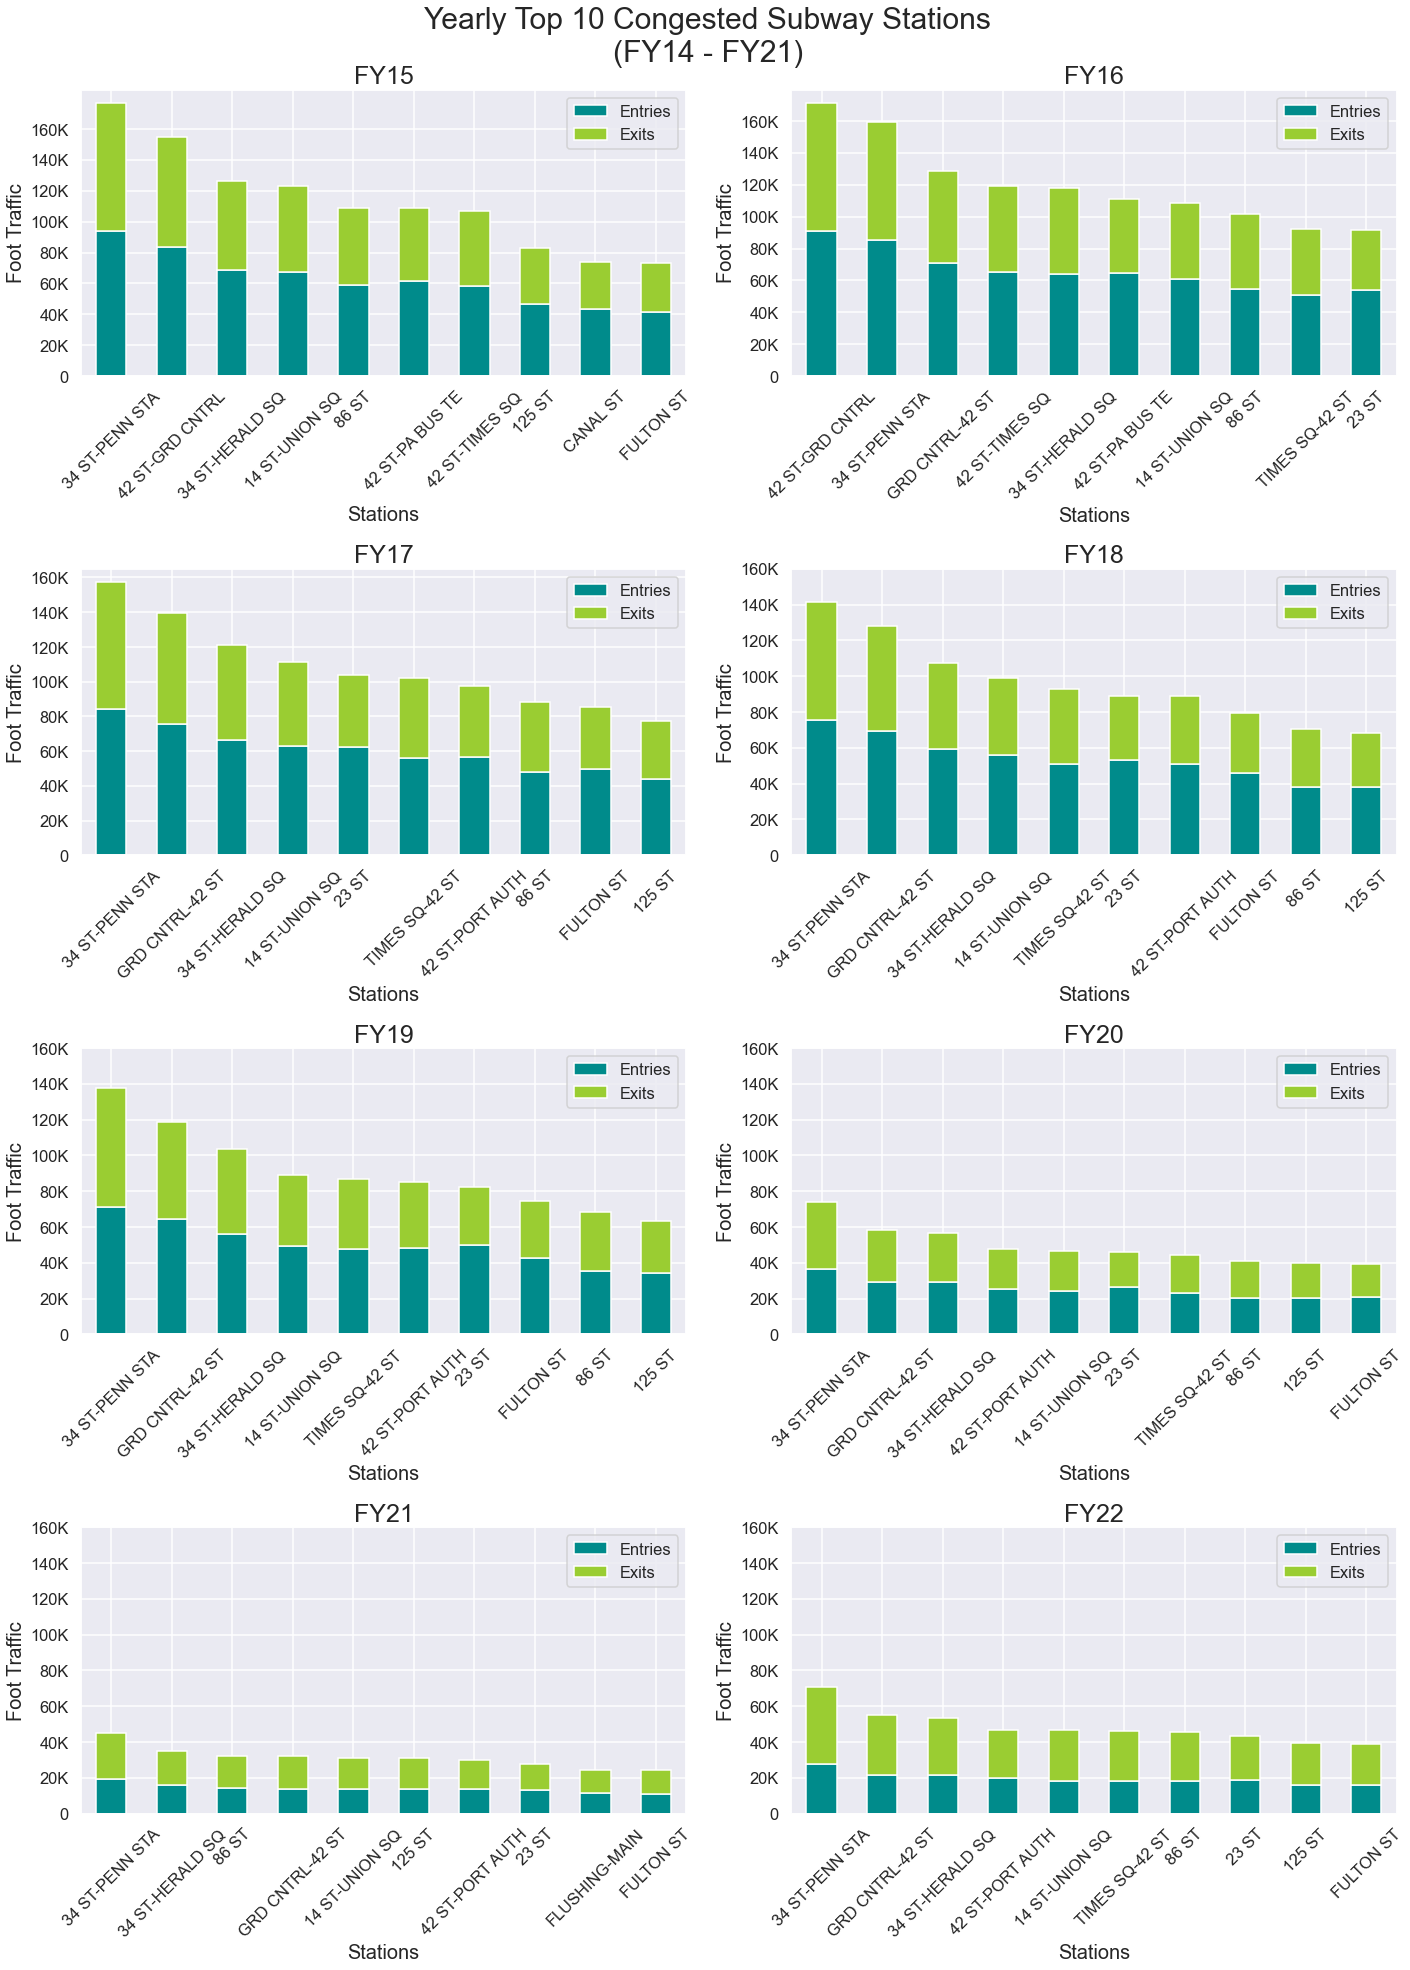

In [116]:
'''
Take a closer look at the Top 10 congested Subway Stations by year
Note: Broken up by U.S. Federal Fiscal Year Calendar
'''

fig, axes = plt.subplots(4,2, figsize=(20,28))

# Copy Data
df_plot = mta_df[["Date", "Fiscal Year", "Station", "Entries", "Exits", "Traffic"]].copy()
# Group by day, year, DOW and aggregate the sum
df_plot = df_plot.groupby(["Date", "Fiscal Year", "Station"], as_index=False).sum()
# Group by Fiscal Year and DOW and take the DOW mean
df_plot = df_plot.groupby(["Fiscal Year", "Station"], as_index=False).mean()

# bigger plot elements suitable for giving talks
sns.set_context("talk")

# set tick labels
ytick_labels = np.array(["0", "20K", "40K", "60K", "80K", "100K", "120K", "140K", "160K"])

# Set axes indices
i = 0
j = 0
# Loop over years
for year in range(2015,2023):
    # Filter by FY
    # create stacked bar chart
    df_plot[df_plot["Fiscal Year"] == year].sort_values(["Traffic"], 
                                                        ascending=False)[:10].drop(["Traffic"], 
                                                                                   axis=1).set_index("Station").drop("Fiscal Year", 
                                                                                                                     axis=1).plot(kind="bar", 
                                                                                                                                  stacked=True, 
                                                                                                                                  color=['darkcyan', 'yellowgreen'], 
                                                                                                                                  ax=axes[i,j])
    
    # set axes ticks
    # plt.xticks(np.arange(0,6), xtick_labels, fontsize=15)
    # plt.xticks(rotation=0)
    # axes[i,j].set_xticks(np.arange(0,6))
    axes[i,j].set_xticklabels(axes[i,j].get_xticklabels(), rotation=45)
    axes[i,j].set_yticks(np.arange(0,165e3, 20e3))
    axes[i,j].set_yticklabels(ytick_labels)
    # set axes title's and labels
    axes[i,j].set_title("FY{}".format(year-2000), fontsize=25)
    axes[i,j].set_xlabel("Stations", fontsize=20)
    axes[i,j].set_ylabel("Foot Traffic", fontsize=20)
    # Perform index manipulation 
    if j < 1:
        j += 1
    else:
        i += 1
        j = 0
# set fig suptitle
fig.suptitle("Yearly Top 10 Congested Subway Stations\n(FY14 - FY21)", fontsize=30)

# save image as PNG file
plt.savefig("./img/FiscalYearly_Top10Stations.png", 
            dpi=150)

#display figure
plt.tight_layout()
plt.show()

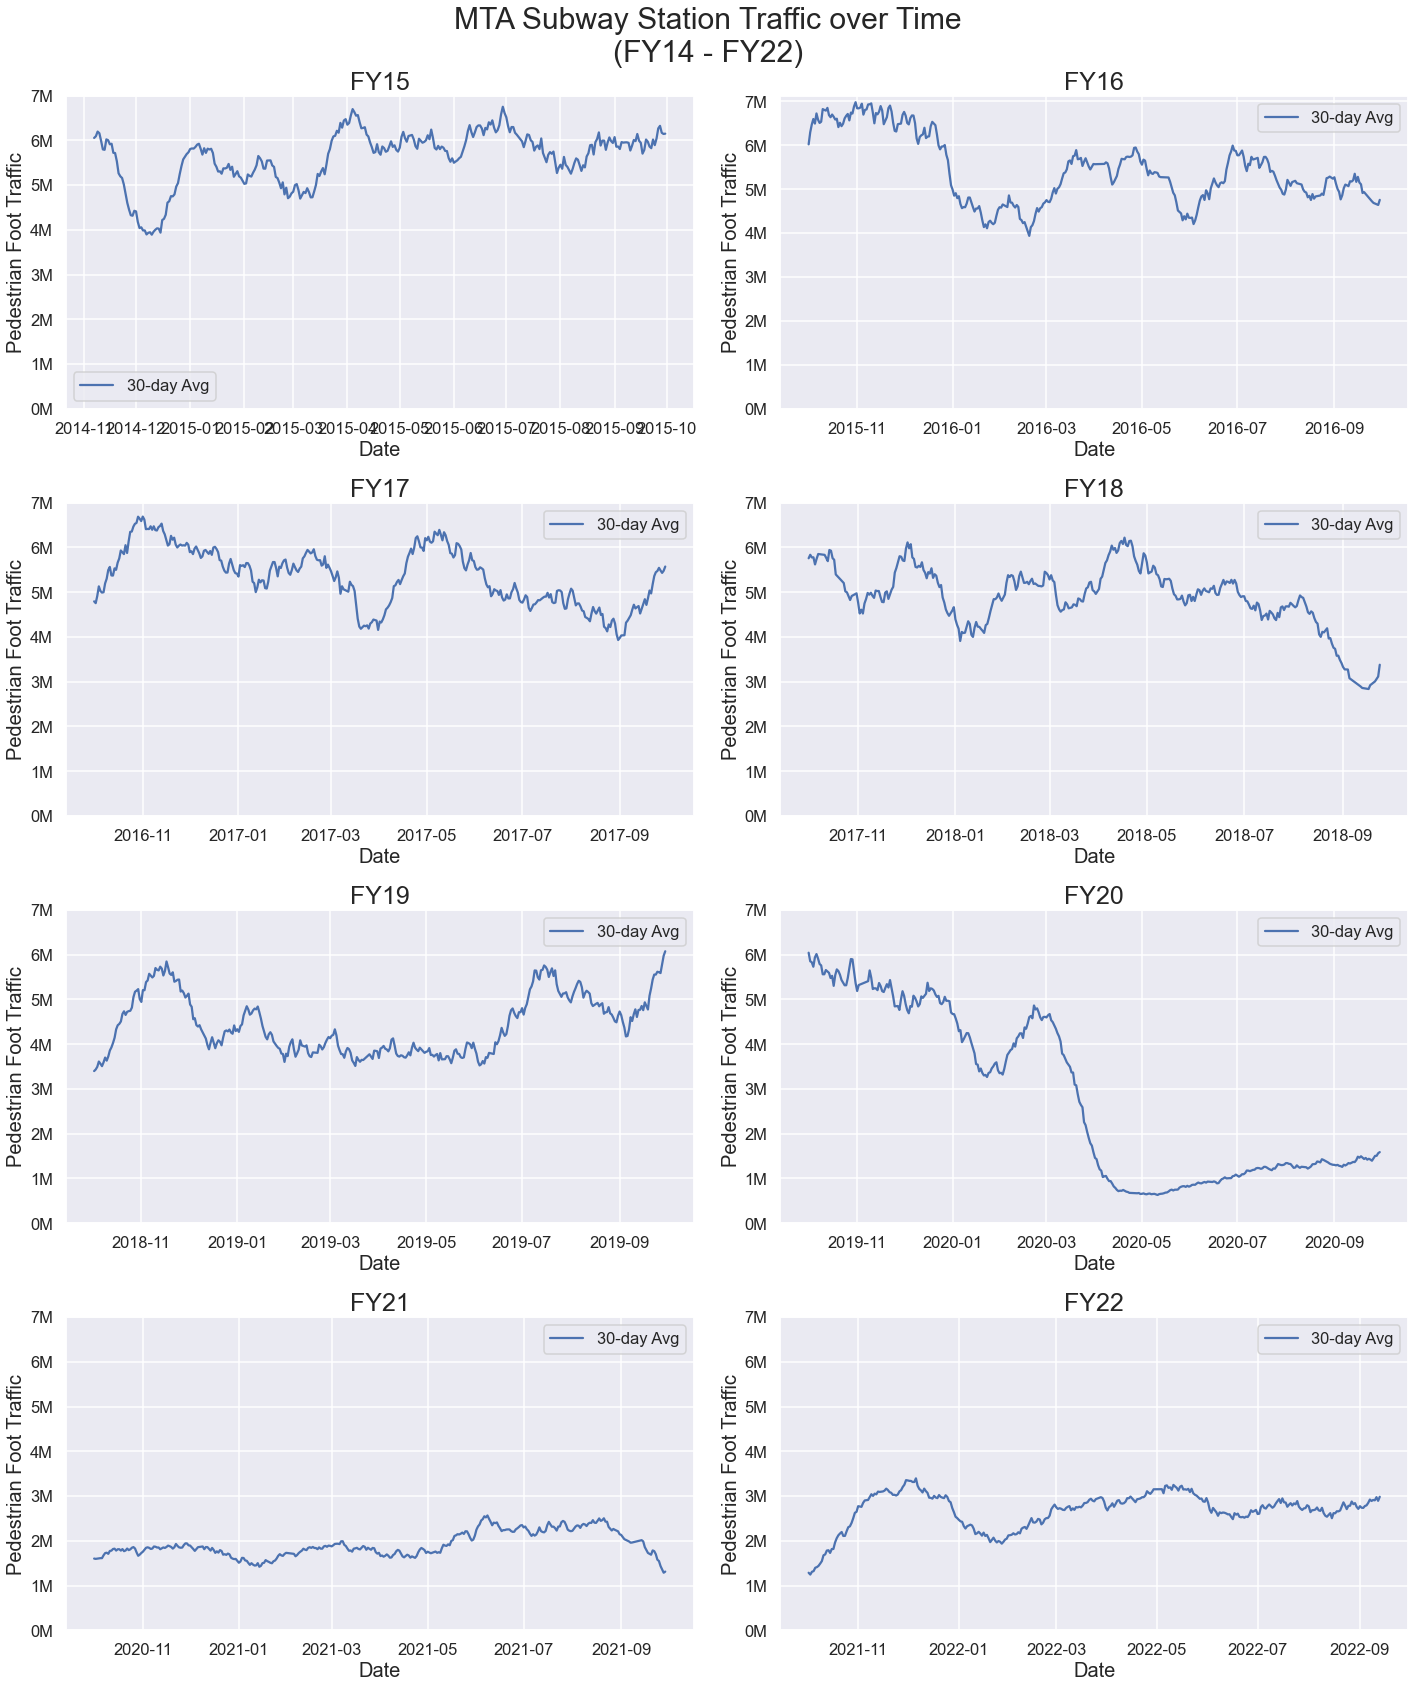

In [68]:
'''
Take a closer look at the 30-day moving average over the years
Note: Broken up by U.S. Federal Fiscal Year Calendar
'''

fig, axes = plt.subplots(4,2, figsize=(20,24))

# Copy Data
df_plot = mta_df[["Date", "Fiscal Year", "Traffic"]].copy()
# Group by day, year and aggregate the sum
df_plot = df_plot.groupby(["Date", "Fiscal Year"], as_index=False).sum()
# Create 30-day rolling average for Traffic
df_plot['Traffic_30day_ave'] = df_plot.Traffic.rolling(30).mean().shift(-3)

# bigger plot elements suitable for giving talks
sns.set_context("talk")

# Set axes indices
i = 0
j = 0
# Loop over years
for year in range(2015,2023):
    # Line Plot displaying 7day rolling average Traffic
    sns.lineplot(x="Date" ,y="Traffic_30day_ave",
                 label="30-day Avg",
                 data=df_plot[df_plot["Fiscal Year"] == year],
                 ci=None,
                 ax=axes[i,j])
    # set axis labels
    axes[i,j].set_xlabel("Date", size=20)
    axes[i,j].set_ylabel("Pedestrian Foot Traffic", size=20)
    # set axis ticks
    axes[i,j].set_yticks(np.arange(0, 8e6, 8e6//8))
    axes[i,j].set_yticklabels(np.array(["0M", "1M", "2M", "3M", "4M", "5M", "6M", "7M"]))
    # set axes title
    axes[i,j].set_title("FY{}".format(year-2000), fontsize=25)
    # Perform index manipulation 
    if j < 1:
        j += 1
    else:
        i += 1
        j = 0
# set fig title NOTE: SupTitle will not save
fig.suptitle("MTA Subway Station Traffic over Time\n(FY14 - FY22)", fontsize=30)
# save image as PNG file
plt.savefig("./img/FiscalYearly_30day_average_by_year_Traffic_Oct2014_Sept2022.png", dpi=150)

# Display Image
plt.tight_layout()
plt.show()